In [1]:
from google.cloud import storage
import scipy
from scipy import signal
from scipy.signal import find_peaks
from scipy import stats
from scipy.stats import shapiro
import numpy as np
import pandas as pd
import os
import sys
import scipy.interpolate as interp
sys.path.append(os.path.join(sys.path[0], '..', 'src'))
import excel_reader_gcp as excel_reader
import excel_reader_gcp_GN as excel_reader_GN
print("The module is located at:", excel_reader.__file__)
import datetime
import logging   
import csv
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
import random
import copy
import re

The module is located at: c:\GP-WearablesAnalysis\examples\excel_reader_gcp.py


In [ ]:
""" This notebook is used for all random evaluations/testing before being implemented into other scripts"""

In [75]:
""" Data grouping/splitting pipeline:"""

""" Split the data into desired number of groups, and extract the first "target mean" from the first group. Subsequent target means are calculated as X% (percent grading) away from previous groups
    ex. if 3% is selected, means of groups will increment by 3% - the direction of incrementing (up/down) depends on whether reverse is selected 
    Iterate through indices in the gait parameter data (in this case, STSR) and append to a grouping if they are within a threshold from the target mean. 
    Sort both the gait parameter and corresponding gait cycles based on the chosen indices. 
"""

def finding_groupings(num_groups, gait_parameter, gait_cycles, percent_grading, reverse=True):
    
    if reverse:
        percent_grading = -percent_grading
        values_sorted = sorted(gait_parameter, reverse=True)
        sorted_indices = np.argsort(gait_parameter)[::-1]  # Sort indices in descending order of stance time symmetry
    else:
        sorted_indices = np.argsort(gait_parameter)
        values_sorted = sorted(gait_parameter, reverse=False)

    n = len(gait_parameter)
    group_sizes = [n // num_groups + (1 if i < n % num_groups else 0) for i in range(num_groups)]
    target_means = [np.mean(values_sorted[:group_sizes[0]])]

    # Initializes the groups and the remaining values to be picked from
    groups = [[] for _ in range(num_groups)]
    grouped_gait_cycles = [[] for _ in range(num_groups)]
    remaining_indices = sorted_indices[:]

    for i in range(1, num_groups):
        target_means.append(target_means[0] + percent_grading * i)

    for i in range(num_groups):
        target_mean = target_means[i]
        filtered_indices = [idx for idx in remaining_indices if abs(gait_parameter[idx] - target_mean) < percent_grading / 2]
        selected_indices = filtered_indices[:]
        groups[i].extend(gait_parameter[idx] for idx in selected_indices)
        grouped_gait_cycles[i].extend(gait_cycles[idx] for idx in selected_indices)
        remaining_indices = [idx for idx in remaining_indices if idx not in selected_indices]

    return groups, grouped_gait_cycles, percent_grading            

""" Random Sampling Gait Cycles:"""

""" random_sampling: Randomly sample 50 gait cycles from group 1. This serves as the "first_mean" that will be compared to in adaptive subsampling.
    adaptive_subsample: Randomly sample 50 gait cycles from a given group. If it is within X% * i +/- tolerance (i is the index of the group (ex. group 2 = 1)), then that group is accepted.
    Otherwise, the maximum or minimum is removed and another value still available is added (depending on if the current percent difference is too high or too low)
    Handles if the means are decreasing or increasing (if percent_diff is negative or positive)
    Returns the indices of the groups, and these are used to update the new groups in random_sampling.
"""

def random_sampling(groups, grouped_gait_cycles, sample_size=50):
    def adaptive_subsample(group, first_mean, i, percent_grading= 0.03, tolerance=0.005, sample_size=50, max_iterations=10000):
        available_indices = list(range(len(group)))  # Make a list that spans all the indices
        sample_indices = np.random.choice(available_indices, size=sample_size, replace=False)
        
        for idx in sample_indices:
            available_indices.remove(idx)  # Remove initial sample values from available values
        for _ in range(max_iterations):
            current_mean = np.mean([group[idx] for idx in sample_indices])
            percent_diff = current_mean - first_mean 
            target_diff = percent_grading * i

            if len(available_indices) == 0:
                raise ValueError("No candidates available to adjust the mean")
            
            if (target_diff - tolerance) <= abs(percent_diff) <= (target_diff + tolerance):
                return sample_indices
            
            if abs(percent_diff) < (target_diff - tolerance):
                if percent_diff < 0:
                    # Choose a new sample from the lower half
                    lower_idx = [idx for idx in available_indices if group[idx] <= np.percentile(group, 50)]
                    if lower_idx:
                        new_idx = np.random.choice(lower_idx)
                        sample_indices = np.append(sample_indices, new_idx)
                    else:
                        new_idx = np.random.choice(available_indices)
                        sample_indices = np.append(sample_indices, new_idx)
                    
                    available_indices.remove(new_idx)
                    sample_indices = np.delete(sample_indices, np.argmax([group[idx] for idx in sample_indices]))
                else:
                    # Choose a new sample from the upper half
                    higher_idx = [idx for idx in available_indices if group[idx] >= np.percentile(group, 50)]
                    if higher_idx:
                        new_idx = np.random.choice(higher_idx)
                        sample_indices = np.append(sample_indices, new_idx)
                    else:
                        new_idx = np.random.choice(available_indices)
                        sample_indices = np.append(sample_indices, new_idx)
                    
                    available_indices.remove(new_idx)
                    sample_indices = np.delete(sample_indices, np.argmin([group[idx] for idx in sample_indices]))
            else:
                if percent_diff > 0:
                    lower_idx = [idx for idx in available_indices if group[idx] <= np.percentile(group, 50)]
                    if lower_idx:
                        new_idx = np.random.choice(lower_idx)
                        sample_indices = np.append(sample_indices, new_idx)
                    else:
                        new_idx = np.random.choice(available_indices)
                        sample_indices = np.append(sample_indices, new_idx)
                    
                    available_indices.remove(new_idx)
                    sample_indices = np.delete(sample_indices, np.argmax([group[idx] for idx in sample_indices]))
                else:
                    # Choose a new sample from the upper half
                    higher_idx = [idx for idx in available_indices if group[idx] >= np.percentile(group, 50)]
                    if higher_idx:
                        new_idx = np.random.choice(lower_idx)
                        sample_indices = np.append(sample_indices, new_idx)
                    else:
                        new_idx = np.random.choice(available_indices)
                        sample_indices = np.append(sample_indices, new_idx)
                    
                    available_indices.remove(new_idx)
                    sample_indices = np.delete(sample_indices, np.argmin([group[idx] for idx in sample_indices]))

        raise ValueError("Could not find suitable subsample within the maximum number of iterations")

    indices_first_group = list(range(len(groups[0])))  
    sample_indices_first_group = np.random.choice(indices_first_group, size=sample_size*2, replace=False)
    group1_mean = np.mean([groups[0][idx] for idx in sample_indices_first_group]) # first mean used as the target for all subsequent groups
    
    random.shuffle(sample_indices_first_group)
    baseline_1_indices = sample_indices_first_group[:50]
    baseline_2_indices = sample_indices_first_group[50:]
    
    subsampled_values_baseline1 = [groups[0][j] for j in baseline_1_indices]
    subsampled_gait_cycles_baseline1 = [grouped_gait_cycles[0][j] for j in baseline_1_indices]
    
    subsampled_values_baseline2 = [groups[0][j] for j in baseline_2_indices]
    subsampled_gait_cycles_baseline2 = [grouped_gait_cycles[0][j] for j in baseline_2_indices]
    
    groups_subsampled_list = []
    gaitcycles_subsampled_list = []
    
    groups_subsampled_list.append(subsampled_values_baseline1)
    groups_subsampled_list.append(subsampled_values_baseline2)
    
    gaitcycles_subsampled_list.append(subsampled_gait_cycles_baseline1)
    gaitcycles_subsampled_list.append(subsampled_gait_cycles_baseline2)
    
    #Only consider 3 groups here
    for i in range(1, 3):
        sample_indices = adaptive_subsample(np.array(groups[i]), group1_mean, i)
        subsampled_values = [groups[i][j] for j in sample_indices]
        subsampled_gait_cycles = [grouped_gait_cycles[i][j] for j in sample_indices]
        groups_subsampled_list.append(subsampled_values)
        gaitcycles_subsampled_list.append(subsampled_gait_cycles)
    
    return groups_subsampled_list, gaitcycles_subsampled_list

""" Group splitting and sampling are called. Checks to see which direction the grouping should be done in, and only appends the groups that have at least 70 points"""

def check_group_configurations(gait_split_parameter, raw_sensor_data, num_groups):
    percent_grading = 0.03
    groups, grouped_gait_cycles, grading = finding_groupings(num_groups, gait_split_parameter, raw_sensor_data, percent_grading, reverse=False)
    
    filtered_groups = []
    filtered_gait_groups = []
    
    for i in range(len(groups)):
        if len(groups[i]) > 70:
            filtered_groups.append(groups[i])
            filtered_gait_groups.append(grouped_gait_cycles[i])
    
    if len(filtered_groups) < 3:
        groups, grouped_gait_cycles, grading = finding_groupings(num_groups, gait_split_parameter, raw_sensor_data, percent_grading, reverse=True)  # Try the other direction if requirements are not fulfilled
        filtered_groups = []
        filtered_gait_groups = []
        
        for i in range(len(groups)):
            if len(groups[i]) > 70:
                filtered_groups.append(groups[i])
                filtered_gait_groups.append(grouped_gait_cycles[i])

        if len(filtered_groups) < 3:
            raise ValueError("Insufficient group sizes available for this participant")
    
    groups, gaitcycles = random_sampling(filtered_groups, filtered_gait_groups)
    
    return groups, gaitcycles

Processing participant LLPU_P01
Prosthetic on the right side
(1, 51, 3)
(1, 51, 3)


<Figure size 640x480 with 0 Axes>

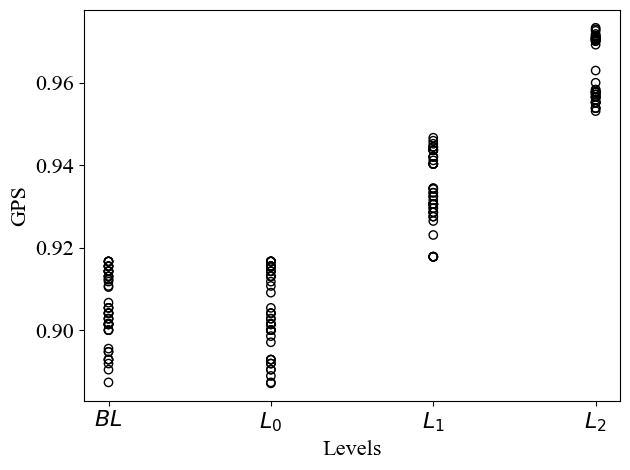

<Figure size 640x480 with 0 Axes>

In [102]:
"""Main section of code for processing participants"""
import gait_metrics as gait_metrics
from gait_metrics import *
#Dictionary to map the sensor locations to their IDs.
sensor_mappings = {
    'pelvis': 1,
    'UpperR': 2,
    'LowerR': 3,
    'UpperL': 5,
    'LowerL': 6
}

XsensGaitParser =  excel_reader.XsensGaitDataParser()
storage_client = storage.Client()
bucket_name = 'gaitbfb_propellab/'
base_directory = bucket_name + 'Wearable Biofeedback System (REB-0448)/Data/Raw Data'
bucket_name = 'gaitbfb_propellab'
blobs = storage_client.list_blobs(bucket_name, prefix = base_directory)
prefix_from_bucket = 'Wearable Biofeedback System (REB-0448)/Data/Raw Data/' 

#participant_list = ['LLPU_P01','LLPU_P02','LLPU_P03','LLPU_P04','LLPU_P05','LLPU_P06','LLPU_P08','LLPU_P09','LLPU_P10','LLPU_P12','LLPU_P14','LLPU_P15']
#participant_list = ['LLPU_P01','LLPU_P02','LLPU_P03','LLPU_P04','LLPU_P05','LLPU_P06','LLPU_P08','LLPU_P09','LLPU_P10','LLPU_P12','LLPU_P15']
#participant_list = ['LLPU_P09','LLPU_P10','LLPU_P12','LLPU_P15']
participant_list = ['LLPU_P01']
arrangements = ['pelvis','upper','lower']

STSR_full = []
StepLength_full = []
GPS_full = []

participant_info = pd.read_excel('Q:\\main_propellab\\Users\\Ng, Gabe\\Summer Student 2024\\LLPU_DataSummaries\\LLPU_Height_ProstheticSide.xlsx')

def get_participant_info(participant_id):
    participant = participant_info[participant_info['Participant_ID'] == participant_id]
    if not participant.empty:
        height = participant.iloc[0]['Height']
        side = int(participant.iloc[0]['Side'])
        return height, side
    else:
        return None, None

#Dictionary to map the sensor locations to their IDs.
sensor_mappings = {
    'pelvis': 1,
    'UpperR': 2,
    'LowerR': 3,
    'UpperL': 5,
    'LowerL': 6
}
     
for participant in participant_list:
    print(f"Processing participant {participant}")
    
    participant_id = participant
    height,side = get_participant_info(participant_id)
    height_m = height/100 
    
    if side == 1:
        prosth_side = 0 #Right side
        non_prosth_side = 1
        side_label = "Right"
        print("Prosthetic on the right side")
    else:
        prosth_side = 1 #Left side
        non_prosth_side = 0
        side_label = "Left"
        print("Prosthetic side on the left side")
    
    if height is None or side is None:
        print(f"Participant info not found for ID: {participant_id}")
        continue
    
    directory = prefix_from_bucket + participant + '/Excel_Data_Trimmed'
    blobs = storage_client.list_blobs(bucket_or_name=bucket_name, prefix=directory.replace("\\", "/"))
    part_strides = {}
    part_gait_params = {}
    part_kinematic_params = {}
    part_raw_sensor = []
    trial_type = 'LLPU'
    height_normalized = True
    
    part_strides_baseline = {}
    part_gait_params_baseline = {}
    part_kinematic_params_baseline = {}
    part_sensor_data_baseline = []
    
    knee_roms_list = []
    hip_roms_list = []
    step_lengths_list = []
    ankle_roms_list = []
    
    def reshape_vector(vectors_orig, new_size, num_axes=3):
        x_new = np.linspace(0, 100, new_size)
        trial_reshaped = []
        for stride in vectors_orig:
            x_orig = np.linspace(0, 100, len(stride))
            func_cubic = [interp.interp1d(x_orig, stride[:, i], kind='cubic') for i in range(num_axes)]
            vec_cubic = np.array([func_cubic[i](x_new) for i in range(num_axes)]).transpose()
            trial_reshaped.append(vec_cubic)
        return np.array(trial_reshaped)

    def organize_signals(sensor_mappings, gyro_signal, accel_signal):
        combined_signals = {}
        for location, sensor in sensor_mappings.items():
            reshaped_gyro = reshape_vector(gyro_signal[sensor], 40, 3)
            reshaped_accel = reshape_vector(accel_signal[sensor], 40, 3)
            combined_signals[location] = np.concatenate((reshaped_gyro, reshaped_accel), axis=2) #Concatenates to gyro x,y,z and accel x,y,z
        return combined_signals

   
    logging.info(f"Processing participant {participant}")
    if blobs:
        for blob in blobs:
            if blob.name.endswith('.csv'):
                try:
                    XsensGaitParser.process_mvn_trial_data(f"gs://{bucket_name}/{blob.name}")
                    partitioned_mvn_data = XsensGaitParser.get_partitioned_mvn_data()
                    gait_params = XsensGaitParser.get_gait_param_info()
                    combined_signals = organize_signals(sensor_mappings, partitioned_mvn_data['gyro_data'], partitioned_mvn_data['acc_data'])
                    pelvis_data = combined_signals['pelvis']
                    upper_data = np.concatenate((combined_signals['UpperR'], combined_signals['UpperL']), axis=2)  # Concatenate by last axis
                    lower_data = np.concatenate((combined_signals['LowerR'], combined_signals['LowerL']), axis=2)  # Concatenate by last axis
                    full_sensors = np.concatenate((pelvis_data,upper_data,lower_data),axis=2)
                    part_raw_sensor.append(full_sensors)

                    if trial_type in part_strides:
                        for body_part in part_strides[trial_type]:
                            for i, side in enumerate(part_strides[trial_type][body_part]):
                                # for each part (pelvis, l_hip, r_knee, etc.), append strides to appropriate list
                                part_strides[trial_type][body_part][i] = part_strides[trial_type][body_part][i] + partitioned_mvn_data[body_part][i]
                               
                        part_gait_params[trial_type].append(gait_params['spatio_temp'])
                        
                        for joint in part_kinematic_params[trial_type]:
                            for i, side in enumerate(part_kinematic_params[trial_type][joint]):
                                part_kinematic_params[trial_type][joint][i] = np.append(part_kinematic_params[trial_type][joint][i], gait_params['kinematics'][joint][i], axis=0) 

                    else:
                        part_strides[trial_type] = partitioned_mvn_data
                        part_gait_params[trial_type] = [gait_params['spatio_temp']]
                        part_kinematic_params[trial_type] = gait_params['kinematics']
                    file_name = os.path.basename(blob.name)
                    
                    # def get_roms_sideofinterest(roms, side):
                    #     return [sublist[side] for sublist in [[sublist[0][-1], sublist[1][-1]] for sublist in roms]]

                    # # Extract parameters
                    # knee_roms = gait_params['spatio_temp'][13]
                    # hip_roms = gait_params['spatio_temp'][14]
                    # ankle_roms = gait_params['spatio_temp'][15]
                    # step_lengths = gait_params['spatio_temp'][10]

                    # # Get ROMs for the side of interest
                    # knee_roms_list.append(get_roms_sideofinterest(knee_roms, non_prosth_side))
                    # hip_roms_list.append(get_roms_sideofinterest(hip_roms, non_prosth_side))
                    # ankle_roms_list.append(get_roms_sideofinterest(ankle_roms, non_prosth_side))

                    # # Normalize step length if required
                    # step_length = step_lengths[prosth_side] / height_m if height_normalized else step_lengths[prosth_side]
                    # step_lengths_list.append(step_length)
                      
                        
                except IndexError as e: #Exception based on an Index Error encountered in excel_reader_gcp.py **
                    #print(f"File skipped: gs://{bucket_name}/{blob.name} due to error: {e}")
                    continue                              
    
    if trial_type in part_gait_params:
        
        stance_time_symmetry = [item for sublist in [i[11] for i in part_gait_params[trial_type]] for item in sublist]
        knee_ROM = [item for sublist in knee_roms_list for item in sublist]
        step_lengths = [item for sublist in step_lengths_list for item in sublist]
        hip_ROM = [item for sublist in hip_roms_list for item in sublist] 
        ankle_ROM = [item for sublist in ankle_roms_list for item in sublist] 
    
    
        partitioned_awinda_gait = {}
        partitioned_awinda_gait['pelvis_orient'] = reshape_vector(part_strides[trial_type]['pelvis_orient'][0], new_size = 51)
        partitioned_awinda_gait['hip_angle'] = [reshape_vector(part_strides[trial_type]['hip_angle'][0], new_size = 51), reshape_vector(part_strides[trial_type]['hip_angle'][1], new_size = 51)]
        partitioned_awinda_gait['knee_angle'] = [reshape_vector(part_strides[trial_type]['knee_angle'][0], new_size = 51), reshape_vector(part_strides[trial_type]['knee_angle'][1], new_size = 51)]
        partitioned_awinda_gait['ankle_angle'] = [reshape_vector(part_strides[trial_type]['ankle_angle'][0], new_size = 51), reshape_vector(part_strides[trial_type]['ankle_angle'][1], new_size = 51)]


        # Extract and reshape individual signals
        individual_signals = []
        gait_scores_list = []


        for i in range(partitioned_awinda_gait['pelvis_orient'].shape[0]):
            signal_dict = {
                'pelvis_orient': partitioned_awinda_gait['pelvis_orient'][i].reshape(1, 51, 3),
                'hip_angle': [partitioned_awinda_gait['hip_angle'][0][i].reshape(1, 51, 3), partitioned_awinda_gait['hip_angle'][1][i].reshape(1, 51, 3)],
                'knee_angle': [partitioned_awinda_gait['knee_angle'][0][i].reshape(1, 51, 3), partitioned_awinda_gait['knee_angle'][1][i].reshape(1, 51, 3)],
                'ankle_angle': [partitioned_awinda_gait['ankle_angle'][0][i].reshape(1, 51, 3), partitioned_awinda_gait['ankle_angle'][1][i].reshape(1, 51, 3)]
            }
            individual_signals.append(signal_dict)

        print(np.shape(individual_signals[0]['pelvis_orient']))    
        print(np.shape(individual_signals[0]['hip_angle'][0]))

        for signal_val in individual_signals:
            gait_scores = calc_gait_profile_score(signal_val, partitioned_awinda_control)
            gait_scores_list.append(gait_scores)

        GPS_full.append(gait_scores_list)
        
        
        flattened_raw_sensor = []
        for sublist in part_raw_sensor:
            for item in sublist:
                flattened_raw_sensor.append(item) #Flatten to individual gait cycles 
                
        #ordered_groups_GPS, ordered_gaitcycles = check_group_configurations(gait_scores_list, flattened_raw_sensor,3)
        if participant == 'LLPU_P08':
            ordered_groups, ordered_gaitcycles = check_group_configurations(stance_time_symmetry, flattened_raw_sensor,6)
        else:
            ordered_groups_STSR, ordered_gaitcycles = check_group_configurations(stance_time_symmetry, flattened_raw_sensor,4)
        
        
        
        plt.figure()
        plt.rcParams["font.family"] = "serif"
        plt.rcParams["font.serif"] = "Times New Roman"
        plt.rcParams["text.usetex"] = False
        label = [r'$\mathit{BL}$', r'$\mathit{L}_{0}$', r'$\mathit{L}_{1}$', r'$\mathit{L}_{2}$']

        plt.figure()

        for level, group in enumerate(ordered_groups_STSR):
            for value in group:
                plt.scatter(level, value, color='black', facecolors='None')

        # Set tick parameters and labels
        plt.tick_params(axis='both', which='major', labelsize=16)
        plt.ylabel("GPS", fontsize=16)
        plt.xlabel("Levels", fontsize=16)

        # Apply the labels directly to the x-ticks
        plt.xticks(ticks=range(len(label)), labels=label)

        plt.tight_layout()
        plt.show()
        plt.savefig(f'Q:\\main_propellab\\Users\\Ng, Gabe\\Summer Student 2024\\Manuscript\\Potential_Plots\\distributions_GPS_{participant}.svg')

0.00343339313822365
0.004000688592028884
0.003586582110237365
0.0030098032489313804


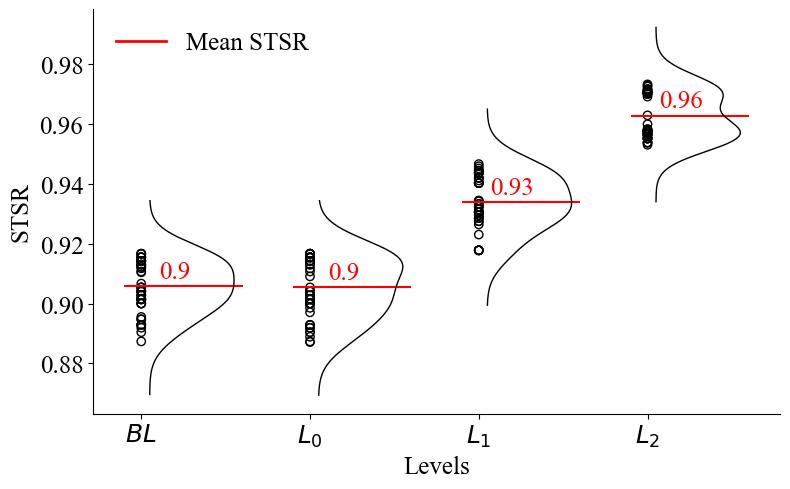

In [104]:
import scipy.stats as stats
import matplotlib as mpl
import latex
import sklearn
from sklearn.neighbors import KernelDensity
plt.rcParams["text.usetex"] = False
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"


# Mathtext formatted labels with italic text and underscored numbers
label = [r'$\mathit{BL}$', r'$\mathit{L}_{0}$', r'$\mathit{L}_{1}$', r'$\mathit{L}_{2}$']

fig, ax = plt.subplots(figsize=(8, 5))
def silverman_bandwidth(data):
    """
    Calculate the bandwidth using Silverman's rule of thumb.
    """
    n = len(data)
    std_dev = np.std(data, ddof=1)
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    bandwidth = 0.9 * min(std_dev, iqr / 1.34) * n ** (-1 / 5.0)
    return bandwidth

def scott_bandwidth(data):
    """
    Calculate the bandwidth using Scott's rule of thumb.
    """
    n = len(data)
    std_dev = np.std(data, ddof=1)
    bandwidth = std_dev * n ** (-1 / 5.0)
    return bandwidth

# Create a list to store the limits of KDE plots
kde_limits = []

for level, group in enumerate(ordered_groups_STSR):
    # Plot scatter points
    
    shapiro_test = stats.shapiro(group)
    if shapiro_test.pvalue > 0.05:
        print("Normal")
    
    for value in group:
        ax.scatter(level, value, color='black', facecolors='None')
    
    # Plot mean lines for the first, third, and fourth groups
    if level in [0, 1, 2, 3]:
        group_mean = np.mean(group)
        ax.hlines(y=group_mean, xmin=level - 0.1, xmax=level + 0.6, colors='red')

        # Find the last scatter point for the level
        last_point = max(group)
        
        # Place the label just above the last scatter point
        ax.text(x=level+ 0.2, y=group_mean + min(group)/1000, s=f'{math.floor(group_mean * 100) / 100.0}', 
                ha='center', va='bottom', fontsize=18, color='red')
    
    # Kernel density estimation for each group
    x_d = np.linspace(min(group) - min(group)/50, max(group) + min(group)/50, 1000)[:, np.newaxis]
    group_array = np.array(group)[:, np.newaxis]
    print(silverman_bandwidth(group))
    adj_val = 0.0025
    kde = KernelDensity(kernel='gaussian', bandwidth=silverman_bandwidth(group)).fit(group_array)
    log_dens = kde.score_samples(x_d)
    
    # Normalize the density plot to fit within the x-axis of the scatter plot
    density = np.exp(log_dens)
    kde_limit = density.max()*2
    kde_limits.append(kde_limit)
    
    # Plot the KDE curve right next to the scatter plot
    ax.plot(level  + 0.05 + density/kde_limit, x_d, color='black', linewidth=1)

# Set tick parameters and labels
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylabel("STSR", fontsize=18)
ax.set_xlabel("Levels", fontsize=18)

# Apply the labels directly to the x-ticks
ax.set_xticks(ticks=range(len(label)))
ax.set_xticklabels(labels=label, fontsize=18, family='serif', fontname='Times New Roman')

# Adjust limits
# ax.set_xlim(-0.5, len(ordered_groups) - 0.5 + 0.4)  # Add extra space for KDE plots
# ax.set_ylim(min(min(group) for group in ordered_groups) - 1, 
#             max(max(group) for group in ordered_groups) + 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

from matplotlib.lines import Line2D
mean_line = Line2D([0], [0], color='red', lw=2, label='Mean STSR')

# Add the legend
ax.legend(handles=[mean_line], loc='upper left', fontsize=18, frameon=False)
#plt.savefig(f'Q:\\main_propellab\\Users\\Ng, Gabe\\Summer Student 2024\\Manuscript\\Potential_Plots\\gaussian_STSR_{participant}_smoothed.svg')
plt.show()
# print(x_d)

In [5]:
### AGGREGATE DATA FOR GPS CALCULATION ###

def reshape_vector(vectors_orig, new_size=40, num_axes=3):
    x_new = np.linspace(0, 100, new_size)
    trial_reshaped = []
    for stride in vectors_orig:
        x_orig = np.linspace(0, 100, len(stride))
        func_cubic = [interp.interp1d(x_orig, stride[:, i], kind='cubic') for i in range(num_axes)]
        vec_cubic = np.array([func_cubic[i](x_new) for i in range(num_axes)]).transpose()
        trial_reshaped.append(vec_cubic)
    return np.array(trial_reshaped)

#uses dictionaries to extract the relevant raw sensor data, reshapes the data, then concatenates gyro and accelerometer signals together 
def organize_signals(sensor_mappings, gyro_signal, accel_signal):
    combined_signals = {}
    for location, sensor in sensor_mappings.items():
        reshaped_gyro = reshape_vector(gyro_signal[sensor], 40, 3)
        reshaped_accel = reshape_vector(accel_signal[sensor], 40, 3)
        combined_signals[location] = np.concatenate((reshaped_gyro, reshaped_accel), axis=2) #Concatenates to gyro x,y,z and accel x,y,z
    return combined_signals

XsensGaitParser =  excel_reader_GN.XsensGaitDataParser()
storage_client = storage.Client()
part_strides = {}
part_gait_params = {}
part_kinematic_params = {}
control_strides = {}
control_gait_params = {}
control_kinematic_params = {}

params_INI = {
            'stride time':[],
            'stride length':[],
            'swing phase':[],
            'MAV':[],
            'MAH':[],
            'MHD':[],
            'MAB':[],
            'MAD':[],
            'ShROM':[]
             }

ini_height_norm = {
            'stride time':False,
            'stride length':True,
            'swing phase':False,
            'MAV':True,
            'MAH':True,
            'MHD':True,
            'MAB':True,
            'MAD':True,
            'ShROM':False
            }
params_temporal_mgs = {
            'stance time':[],
            'swing time':[],
            'double support':[],
            'step time':[],
            'stride time':[]
            }

bucket_dir = 'gs://gaitbfb_propellab/'
def compile_gait_data(store_gait_cycles, store_gait_params, store_kin_params, filenames, trial_type_filter, print_filenames=False, look_at_all_files = True, desired_filetypes=None):   
 
    XsensGaitParser = excel_reader_GN.XsensGaitDataParser()  
    for i, file in enumerate(sorted(filenames)):
        trial_type = re.search(trial_type_filter, file).group(1)

        if(look_at_all_files or any(filetype in file for filetype in desired_filetypes)):
            XsensGaitParser.process_mvn_trial_data(os.path.join(bucket_dir, file))
            partitioned_mvn_data = XsensGaitParser.get_partitioned_mvn_data()
            gait_params = XsensGaitParser.get_gait_param_info()

            if trial_type in store_gait_cycles:
                for body_part in store_gait_cycles[trial_type]:
                    for j, side in enumerate(store_gait_cycles[trial_type][body_part]):
                        # for each part (pelvis, l_hip, r_knee, etc.), append strides to appropriate list
                        store_gait_cycles[trial_type][body_part][j] = store_gait_cycles[trial_type][body_part][j] + partitioned_mvn_data[body_part][j]

                for j, param in enumerate(store_gait_params[trial_type]):
                    store_gait_params[trial_type][j] = np.concatenate( (store_gait_params[trial_type][j], gait_params['spatio_temp'][j]), axis=-1)

                for joint in store_kin_params[trial_type]:
                    for j, side in enumerate(store_kin_params[trial_type][joint]):
                        store_kin_params[trial_type][joint][j] = np.append(store_kin_params[trial_type][joint][j], gait_params['kinematics'][joint][j], axis=0)

            else:
                store_gait_cycles[trial_type] = partitioned_mvn_data
                store_gait_params[trial_type] = gait_params['spatio_temp']
                store_kin_params[trial_type] = gait_params['kinematics']
                
                
bucket_name = 'gaitbfb_propellab/'
base_directory = bucket_name + 'Wearable Biofeedback System (REB-0448)/Data/Raw Data'
bucket_name = 'gaitbfb_propellab'
prefix = 'control_dir'
control_dir = 'Gait Quality Analysis/Data/Participant_Data/Processed Data/AbleBodied_Control/CSV'
blobs = storage_client.list_blobs(bucket_name, prefix = control_dir)
control_files = []
for blob in blobs:
    if('.csv' in blob.name):
        control_files.append(blob.name)
participant_info = pd.read_csv(bucket_dir + 'Gait Quality Analysis/Data/Participant_Data/Raw Data/participant_info.csv')
compile_gait_data(control_strides, control_gait_params, control_kinematic_params, control_files, 'CSV/(.*?)-00')        

aggregate_control_data = {}
strides_per_control = 10
control_strides_per_part = []
for i, indiv in enumerate(control_strides.keys()):
    
    #################################
    indiv_height = participant_info.loc[participant_info['Participant'] == indiv]['Height (m)'].item()
    for j, param in enumerate(params_INI):
        if(ini_height_norm[param]):
            control_gait_params[indiv][j] = control_gait_params[indiv][j] / indiv_height  
    #################################
    
    
    indices = np.arange(len(control_strides[indiv]['gyro_data'][0]))
    np.random.shuffle(indices)
    control_strides_per_part.append(min(strides_per_control, len(indices)))
    
    if(i == 0):
        aggregate_control_data = control_strides[indiv]
        
        for signal_type in control_strides[indiv]:
            for j, side in enumerate(control_strides[indiv][signal_type]):
                aggregate_control_data[signal_type][j] = [control_strides[indiv][signal_type][j][indices[k]] for k in range(min(strides_per_control, len(indices))) ]
                    
        for j, param in enumerate(params_INI.keys()):
            for k in range(2):
                params_INI[param].append([])
                params_INI[param][k] = [control_gait_params[indiv][j][k][indices[a]] for a in range(min(strides_per_control, len(indices))) ]
        
    else:
        # choose 10 gait cycles randomly from each able-bodied participant, or all gait cycles if less than 10
        for signal_type in control_strides[indiv]:
            for j, side in enumerate(control_strides[indiv][signal_type]):
                aggregate_control_data[signal_type][j] = aggregate_control_data[signal_type][j] + [control_strides[indiv][signal_type][j][indices[k]] 
                                                                                                   for k in range(min(strides_per_control, len(indices))) ]
        for j, param in enumerate(params_INI.keys()):
            for k in range(2):
                params_INI[param][k] = params_INI[param][k] + [control_gait_params[indiv][j][k][indices[a]] for a in range(min(strides_per_control, len(indices))) ]
                

                
print('Parsed control data...')
for param in params_INI:
    params_INI[param] = np.array(params_INI[param])
    
for param in params_temporal_mgs:
    params_temporal_mgs[param] = np.array(params_temporal_mgs[param])

        
partitioned_gait_data = []
                
     
    # print(params_INI[param])
# reshape all the kinematic signals to the size specified for the GPS (51, e.g. 2% increments across the gait cycles from HS to HS)
# store in partitioned_awinda_control

# partitioned_awinda_control = {}
# partitioned_awinda_control['pelvis_orient'] = reshape_vector(aggregate_control_data['pelvis_orient'][0], new_size = 51)
# partitioned_awinda_control['hip_angle'] = [reshape_vector(aggregate_control_data['hip_angle'][0], new_size = 51), reshape_vector(aggregate_control_data['hip_angle'][1], new_size = 51)]
# partitioned_awinda_control['knee_angle'] = [reshape_vector(aggregate_control_data['knee_angle'][0], new_size = 51), reshape_vector(aggregate_control_data['knee_angle'][1], new_size = 51)]
# partitioned_awinda_control['ankle_angle'] = [reshape_vector(aggregate_control_data['ankle_angle'][0], new_size = 51), reshape_vector(aggregate_control_data['ankle_angle'][1], new_size = 51)]

class AwindaData():
    def __init__(self, trial_type, partitioned_movement_data, ini_gait_params = None, mgs_temporal_params = None):
        self.trial_type = trial_type
        self.partitioned_movement_data = partitioned_movement_data
        self.ini_gait_params = ini_gait_params
        self.mgs_temporal_params = mgs_temporal_params

def combine_acc_and_gyro(numpy_acc, numpy_gyro):
    return np.concatenate((numpy_acc, numpy_gyro), axis=-1)

partitioned_gait_data = []

partitioned_awinda_control = {}
partitioned_awinda_control['Pelvis_IMU'] = combine_acc_and_gyro(0.02*reshape_vector(aggregate_control_data['acc_data'][1]), reshape_vector(aggregate_control_data['gyro_data'][1]))
partitioned_awinda_control['UpperR_IMU'] = combine_acc_and_gyro(0.02*reshape_vector(aggregate_control_data['acc_data'][2]), reshape_vector(aggregate_control_data['gyro_data'][2]))
partitioned_awinda_control['UpperL_IMU'] = combine_acc_and_gyro(0.02*reshape_vector(aggregate_control_data['acc_data'][5]), reshape_vector(aggregate_control_data['gyro_data'][5]))
partitioned_awinda_control['LowerR_IMU'] = combine_acc_and_gyro(0.02*reshape_vector(aggregate_control_data['acc_data'][3]), reshape_vector(aggregate_control_data['gyro_data'][3]))
partitioned_awinda_control['LowerL_IMU'] = combine_acc_and_gyro(0.02*reshape_vector(aggregate_control_data['acc_data'][6]), reshape_vector(aggregate_control_data['gyro_data'][6]))

partitioned_awinda_control['pelvis_orient'] = reshape_vector(aggregate_control_data['pelvis_orient'][0], new_size = 51)
partitioned_awinda_control['hip_angle'] = [reshape_vector(aggregate_control_data['hip_angle'][0], new_size = 51), reshape_vector(aggregate_control_data['hip_angle'][1], new_size = 51)]
partitioned_awinda_control['knee_angle'] = [reshape_vector(aggregate_control_data['knee_angle'][0], new_size = 51), reshape_vector(aggregate_control_data['knee_angle'][1], new_size = 51)]
partitioned_awinda_control['ankle_angle'] = [reshape_vector(aggregate_control_data['ankle_angle'][0], new_size = 51), reshape_vector(aggregate_control_data['ankle_angle'][1], new_size = 51)]

partitioned_control_data = AwindaData('control', dict(partitioned_awinda_control), dict(params_INI), dict(params_temporal_mgs))
partitioned_gait_data.append(partitioned_control_data)
    

c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=

Parsed control data...


In [3]:
bucket_name = 'gaitbfb_propellab/'
base_directory = bucket_name + 'Wearable Biofeedback System (REB-0448)/Data/Raw Data'
bucket_name = 'gaitbfb_propellab'
blobs = storage_client.list_blobs(bucket_name, prefix = base_directory)
prefix_from_bucket = 'Wearable Biofeedback System (REB-0448)/Data/Raw Data/' 
participant_info = pd.read_csv(bucket_dir + 'Gait Quality Analysis/Data/Participant_Data/Raw Data/participant_info.csv')
participant_list = ['LLPU_P09','LLPU_P10']

def calc_INI(control_mean, control_std, eig_vals, eig_vecs, data):
    standardized_data = (data - control_mean) / control_std
    transformed_data = (np.dot(standardized_data, eig_vecs)) / np.sqrt(eig_vals)
    
    return transformed_data

partitioned_gait_data = [partitioned_control_data]

for participant in participant_list:
    print(f"Processing participant {participant}")
    partitioned_gait_data = [partitioned_control_data]
    directory = prefix_from_bucket + participant + '/Excel_Data_Trimmed'
    blobs = storage_client.list_blobs(bucket_or_name=bucket_name, prefix=directory.replace("\\", "/"))
    part_strides = {}
    part_gait_params = {}
    part_kinematic_params = {}
    part_raw_sensor = []
    trial_type = 'LLPU'
    height_normalized = True
    
    logging.info(f"Processing participant {participant}")
    if blobs:
        for blob in blobs:
            if blob.name.endswith('.csv'):
                try:
                    XsensGaitParser.process_mvn_trial_data(f"gs://{bucket_name}/{blob.name}")
                    partitioned_mvn_data = XsensGaitParser.get_partitioned_mvn_data()
                    gait_params = XsensGaitParser.get_gait_param_info()
                 

                    if participant in part_strides:
                        for body_part in part_strides[trial_type]:
                            for j, side in enumerate(part_strides[trial_type][body_part]):
                                # for each part (pelvis, l_hip, r_knee, etc.), append strides to appropriate list
                                part_strides[trial_type][body_part][j] = part_strides[trial_type][body_part][j] + partitioned_mvn_data[body_part][j]

                        for j, param in enumerate(part_gait_params[trial_type]):
                            part_gait_params[trial_type][j] = np.concatenate((part_gait_params[trial_type][j], gait_params['spatio_temp'][j]), axis=-1)

                        for joint in part_kinematic_params[trial_type]:
                            for j, side in enumerate(part_kinematic_params[trial_type][joint]):
                                part_kinematic_params[trial_type][joint][j] = np.append(part_kinematic_params[trial_type][joint][j], gait_params['kinematics'][joint][j], axis=0)

                    else:
                        part_strides[trial_type] = partitioned_mvn_data
                        part_gait_params[trial_type] = gait_params['spatio_temp']
                        part_kinematic_params[trial_type] = gait_params['kinematics']
                            
                except IndexError as e: #Exception based on an Index Error encountered in excel_reader_gcp.py **
                    #print(f"File skipped: gs://{bucket_name}/{blob.name} due to error: {e}")
                    continue                              
    
    if trial_type in part_gait_params:
        acc_scale = 0.02
       
        partitioned_signals_awinda_grouped = {}
        partitioned_signals_awinda_grouped['Pelvis_IMU'] = combine_acc_and_gyro(acc_scale*reshape_vector(part_strides[trial_type]['acc_data'][1]), reshape_vector(part_strides[trial_type]['gyro_data'][1]))
        partitioned_signals_awinda_grouped['UpperR_IMU'] = combine_acc_and_gyro(acc_scale*reshape_vector(part_strides[trial_type]['acc_data'][2]), reshape_vector(part_strides[trial_type]['gyro_data'][2]))
        partitioned_signals_awinda_grouped['UpperL_IMU'] = combine_acc_and_gyro(acc_scale*reshape_vector(part_strides[trial_type]['acc_data'][5]), reshape_vector(part_strides[trial_type]['gyro_data'][5]))
        partitioned_signals_awinda_grouped['LowerR_IMU'] = combine_acc_and_gyro(acc_scale*reshape_vector(part_strides[trial_type]['acc_data'][3]), reshape_vector(part_strides[trial_type]['gyro_data'][3]))
        partitioned_signals_awinda_grouped['LowerL_IMU'] = combine_acc_and_gyro(acc_scale*reshape_vector(part_strides[trial_type]['acc_data'][6]), reshape_vector(part_strides[trial_type]['gyro_data'][6]))
        
        partitioned_signals_awinda_grouped['pelvis_orient'] = reshape_vector(part_strides[trial_type]['pelvis_orient'][0], new_size = 51)
        partitioned_signals_awinda_grouped['hip_angle'] = [reshape_vector(part_strides[trial_type]['hip_angle'][0], new_size = 51), 
                                                        reshape_vector(part_strides[trial_type]['hip_angle'][1], new_size = 51)]
        partitioned_signals_awinda_grouped['knee_angle'] = [reshape_vector(part_strides[trial_type]['knee_angle'][0], new_size = 51), 
                                                            reshape_vector(part_strides[trial_type]['knee_angle'][1], new_size = 51)]
        partitioned_signals_awinda_grouped['ankle_angle'] = [reshape_vector(part_strides[trial_type]['ankle_angle'][0], new_size = 51), 
                                                            reshape_vector(part_strides[trial_type]['ankle_angle'][1], new_size = 51)]

        
        indiv_height = participant_info.loc[participant_info['Participant'] == participant]['Height (m)'].item()
        for i, param in enumerate(params_INI):
            params_INI[param] = part_gait_params[trial_type][i]
            if(ini_height_norm[param]):
                params_INI[param] = params_INI[param] / indiv_height

        partitioned_gait_data.append(AwindaData(trial_type, dict(partitioned_signals_awinda_grouped), dict(params_INI))) 
        control_INI_params = []
        for param in params_INI:
            control_INI_params.append(partitioned_control_data.ini_gait_params[param][0])
        control_INI_params = np.transpose(np.array(control_INI_params))

        mean_control = np.mean(control_INI_params, axis = 0)
        std_control = np.std(control_INI_params, axis = 0)

        standardized_control = (control_INI_params - mean_control) / std_control
        cov_control = np.cov(standardized_control.T)
        
        eig_vals, eig_vecs = np.linalg.eig(cov_control)
        print(len(partitioned_gait_data))
        for i in range(1,len(partitioned_gait_data)):
            side_1 = np.transpose(np.array( [partitioned_gait_data[i].ini_gait_params[param][0] for param in params_INI] ))
            side_2 = np.transpose(np.array( [partitioned_gait_data[i].ini_gait_params[param][1] for param in params_INI] ))
            test_ini = np.mean([side_1, side_2], axis=0)
            ini_data = calc_INI(mean_control, std_control, eig_vals, eig_vecs, test_ini)
            ini_score = np.mean(np.linalg.norm(ini_data, axis=-1))
            print(ini_score)    

Processing participant LLPU_P09
2
3.6653845568573318
Processing participant LLPU_P10
2
4.106763907356581


In [29]:
# calculating the IMU-based Gait Normalcy Index (INI)

def calc_INI(control_mean, control_std, eig_vals, eig_vecs, data):
    standardized_data = (data - mean_control) / control_std
    transformed_data = (np.dot(standardized_data, eig_vecs)) / np.sqrt(eig_vals)
    
    return transformed_data

control_INI_params = []
for param in params_INI:
    control_INI_params.append(partitioned_control_data.ini_gait_params[param][0])

control_INI_params = np.transpose(np.array(control_INI_params))

mean_control = np.mean(control_INI_params, axis = 0)
print(mean_control)
std_control = np.std(control_INI_params, axis = 0)

standardized_control = (control_INI_params - mean_control) / std_control
cov_control = np.cov(standardized_control.T)

eig_vals, eig_vecs = np.linalg.eig(cov_control)
print(len(partitioned_gait_data))
for i in range(1,len(partitioned_gait_data)):
    side_1 = np.transpose(np.array( [partitioned_gait_data[i].ini_gait_params[param][0] for param in params_INI] ))
    side_2 = np.transpose(np.array( [partitioned_gait_data[i].ini_gait_params[param][1] for param in params_INI] ))
    test_ini = np.mean([side_1, side_2], axis=0)
    ini_data = calc_INI(mean_control, std_control, eig_vals, eig_vecs, test_ini)
    ini_score = np.mean(np.linalg.norm(ini_data, axis=-1))
    print(ini_score)

[ 1.10446735e+00  8.08439751e-01  4.20730420e-01  2.19511572e+00
  1.47669592e-01  2.44365896e-01 -5.02911281e-02 -6.22553228e-03
  7.82490314e+01]
1


In [40]:

def finding_groupings(num_groups, gait_parameter, gait_cycles, part_strides, spatiotemp, percent_grading, reverse=True):
    # (Same code as before until we need to handle part_strides)
    if reverse:
        percent_grading = -percent_grading
        values_sorted = sorted(gait_parameter, reverse=True)
        sorted_indices = np.argsort(gait_parameter)[::-1]  # Sort indices in descending order of stance time symmetry
    else:
        sorted_indices = np.argsort(gait_parameter)
        values_sorted = sorted(gait_parameter, reverse=False)

    n = len(gait_parameter)
    group_sizes = [n // num_groups + (1 if i < n % num_groups else 0) for i in range(num_groups)]
    target_means = [np.mean(values_sorted[:group_sizes[0]])]

    # Initializes the groups and the remaining values to be picked from
    groups = [[] for _ in range(num_groups)]
    grouped_gait_cycles = [[] for _ in range(num_groups)]
    remaining_indices = sorted_indices[:]

    for i in range(1, num_groups):
        target_means.append(target_means[0] + percent_grading * i)

    # Initializes the groups and the remaining values to be picked from
    groups = [[] for _ in range(num_groups)]
    grouped_gait_cycles = [[] for _ in range(num_groups)]
    grouped_strides_dict = [{} for _ in range(num_groups)]
    grouped_spatiotemp_dict = [{} for _ in range(num_groups)]
     
    remaining_indices = sorted_indices[:]

    for i in range(1, num_groups):
        target_means.append(target_means[0] + percent_grading * i)

    params = spatiotemp[trial_type]
    
    for i in range(num_groups):
        target_mean = target_means[i]
        filtered_indices = [idx for idx in remaining_indices if abs(gait_parameter[idx] - target_mean) < percent_grading / 2]
        selected_indices = filtered_indices[:]
        
        groups[i].extend(gait_parameter[idx] for idx in selected_indices)
        grouped_gait_cycles[i].extend(gait_cycles[idx] for idx in selected_indices)
        
        for key, data in part_strides[trial_type].items():
            # Extract the desired indices from each array
            selected_data = []
            for array in data:
                # Check if array is long enough
                if len(array) > max(selected_indices):
                    selected_values = [array[i] for i in selected_indices if i < len(array)]
                    selected_data.append(selected_values)
            grouped_strides_dict[i][key] = selected_data
            
        subsampled_params = []
        for param in params:
            subsampled_param = param[:, selected_indices]
            subsampled_params.append(subsampled_param)
    
        # Add the subsampled arrays to the new dictionary
        grouped_spatiotemp_dict[i] = subsampled_params
        
        remaining_indices = [idx for idx in remaining_indices if idx not in selected_indices]
            
    return groups, grouped_gait_cycles, grouped_strides_dict, grouped_spatiotemp_dict

def random_sampling(groups, grouped_gait_cycles, grouped_strides_dict, grouped_spatiotemp_dict, sample_size=50):
    def adaptive_subsample(group, first_mean, i, percent_grading=0.4, tolerance=0.05, sample_size=50, max_iterations=10000):
        available_indices = list(range(len(group)))  # List of all indices in the group
        sample_indices = np.random.choice(available_indices, size=sample_size, replace=False)
        
        for idx in sample_indices:
            available_indices.remove(idx)  # Remove initial sample values from available values
        
        for _ in range(max_iterations):
            current_mean = np.mean([group[idx] for idx in sample_indices])
            percent_diff = current_mean - first_mean 
            target_diff = percent_grading * i

            if len(available_indices) == 0:
                raise ValueError("No candidates available to adjust the mean")
            
            if (target_diff - tolerance) <= abs(percent_diff) <= (target_diff + tolerance):
                return sample_indices
            
            if abs(percent_diff) < (target_diff - tolerance):
                if percent_diff < 0:
                    # Choose a new sample from the lower half
                    lower_idx = [idx for idx in available_indices if group[idx] <= np.percentile(group, 50)]
                    if lower_idx:
                        new_idx = np.random.choice(lower_idx)
                        sample_indices = np.append(sample_indices, new_idx)
                    else:
                        new_idx = np.random.choice(available_indices)
                        sample_indices = np.append(sample_indices, new_idx)
                    
                    available_indices.remove(new_idx)
                    sample_indices = np.delete(sample_indices, np.argmax([group[idx] for idx in sample_indices]))
                else:
                    # Choose a new sample from the upper half
                    higher_idx = [idx for idx in available_indices if group[idx] >= np.percentile(group, 50)]
                    if higher_idx:
                        new_idx = np.random.choice(higher_idx)
                        sample_indices = np.append(sample_indices, new_idx)
                    else:
                        new_idx = np.random.choice(available_indices)
                        sample_indices = np.append(sample_indices, new_idx)
                    
                    available_indices.remove(new_idx)
                    sample_indices = np.delete(sample_indices, np.argmin([group[idx] for idx in sample_indices]))
            else:
                if percent_diff > 0:
                    lower_idx = [idx for idx in available_indices if group[idx] <= np.percentile(group, 50)]
                    if lower_idx:
                        new_idx = np.random.choice(lower_idx)
                        sample_indices = np.append(sample_indices, new_idx)
                    else:
                        new_idx = np.random.choice(available_indices)
                        sample_indices = np.append(sample_indices, new_idx)
                    
                    available_indices.remove(new_idx)
                    sample_indices = np.delete(sample_indices, np.argmax([group[idx] for idx in sample_indices]))
                else:
                    # Choose a new sample from the upper half
                    higher_idx = [idx for idx in available_indices if group[idx] >= np.percentile(group, 50)]
                    if higher_idx:
                        new_idx = np.random.choice(higher_idx)
                        sample_indices = np.append(sample_indices, new_idx)
                    else:
                        new_idx = np.random.choice(available_indices)
                        sample_indices = np.append(sample_indices, new_idx)
                    
                    available_indices.remove(new_idx)
                    sample_indices = np.delete(sample_indices, np.argmin([group[idx] for idx in sample_indices]))

        raise ValueError("Could not find suitable subsample within the maximum number of iterations")

    groups_subsampled_list = []
    gaitcycles_subsampled_list = []
    
    # Sample for the first group
    indices_first_group = list(range(len(groups[0])))
    sample_indices_first_group = np.random.choice(indices_first_group, size=sample_size * 2, replace=False)
    group1_mean = np.mean([groups[0][idx] for idx in sample_indices_first_group])  # First mean used as the target for all subsequent groups

    random.shuffle(sample_indices_first_group)
    baseline_1_indices = sample_indices_first_group[:50]
    baseline_2_indices = sample_indices_first_group[50:]

    subsampled_values_baseline1 = [groups[0][j] for j in baseline_1_indices]
    subsampled_gait_cycles_baseline1 = [grouped_gait_cycles[0][j] for j in baseline_1_indices]

    subsampled_values_baseline2 = [groups[0][j] for j in baseline_2_indices]
    subsampled_gait_cycles_baseline2 = [grouped_gait_cycles[0][j] for j in baseline_2_indices]

    groups_subsampled_list.append(subsampled_values_baseline1)
    groups_subsampled_list.append(subsampled_values_baseline2)

    gaitcycles_subsampled_list.append(subsampled_gait_cycles_baseline1)
    gaitcycles_subsampled_list.append(subsampled_gait_cycles_baseline2)

    grouped_strides_dict_subsampled = [{} for _ in range(4)]
    grouped_spatiotemp_dict_subsampled = [{} for _ in range(4)]
    
    for key, data in grouped_strides_dict[0].items():
        selected_data = []
        for array in data:
            # Check if array is long enough
            if len(array) > max(baseline_1_indices):
                selected_values = [array[i] for i in baseline_1_indices if i < len(array)]
                selected_data.append(selected_values)
        grouped_strides_dict_subsampled[0][key] = selected_data
    
    for key, data in grouped_strides_dict[0].items():
        selected_data = []
        for array in data:
            # Check if array is long enough
            if len(array) > max(baseline_2_indices):
                selected_values = [array[i] for i in baseline_2_indices if i < len(array)]
                selected_data.append(selected_values)
        grouped_strides_dict_subsampled[1][key] = selected_data  
        
    params = grouped_spatiotemp_dict[0]
    
    subsampled_params = []
    for param in params:
        subsampled_param = param[:, baseline_1_indices]
        subsampled_params.append(subsampled_param)
    # Add the subsampled arrays to the new dictionary
    grouped_spatiotemp_dict_subsampled[0] = subsampled_params
    
    subsampled_params = []
    for param in params:
        subsampled_param = param[:, baseline_2_indices]
        subsampled_params.append(subsampled_param)
    # Add the subsampled arrays to the new dictionary
    grouped_spatiotemp_dict_subsampled[1] = subsampled_params
    
    # Only consider 3 groups here
    for i in range(1, 3):
        sample_indices = adaptive_subsample(np.array(groups[i]), group1_mean, i)
        subsampled_values = [groups[i][j] for j in sample_indices]
        subsampled_gait_cycles = [grouped_gait_cycles[i][j] for j in sample_indices]
        groups_subsampled_list.append(subsampled_values)
        gaitcycles_subsampled_list.append(subsampled_gait_cycles)
        
        for key, data in grouped_strides_dict[i].items():
            selected_data = []
            for array in data:
                # Check if array is long enough
                if len(array) > max(sample_indices):
                    selected_values = [array[i] for i in sample_indices if i < len(array)]
                    selected_data.append(selected_values)
            
            grouped_strides_dict_subsampled[i+1][key] = selected_data  
        
        params = grouped_spatiotemp_dict[i]    
        subsampled_params = []
        for param in params:
            subsampled_param = param[:, sample_indices]
            subsampled_params.append(subsampled_param)
        # Add the subsampled arrays to the new dictionary
        grouped_spatiotemp_dict_subsampled[i+1] = subsampled_params
                
    return groups_subsampled_list, gaitcycles_subsampled_list, grouped_strides_dict_subsampled, grouped_spatiotemp_dict_subsampled


def check_group_configurations(gait_split_parameter, raw_sensor_data, part_strides, spatiotemp):
    percent_grading = 0.4
    groups, grouped_gait_cycles, grouped_strides_dict, grouped_spatiotemp_dict = finding_groupings(4, gait_split_parameter, raw_sensor_data, part_strides, spatiotemp, percent_grading, reverse=False)
    
    filtered_groups = []
    filtered_gait_groups = []
    filtered_strides = []
    filtered_spatiotemp = []
    
    for i in range(len(groups)):
        if len(groups[i]) > 70:
            filtered_groups.append(groups[i])
            filtered_gait_groups.append(grouped_gait_cycles[i])
            filtered_strides.append(grouped_strides_dict[i])
            filtered_spatiotemp.append(grouped_spatiotemp_dict[i])
    
    if len(filtered_groups) < 3:
        groups, grouped_gait_cycles, grouped_strides_dict, grouped_spatiotemp_dict = finding_groupings(4, gait_split_parameter, raw_sensor_data, part_strides, spatiotemp, percent_grading, reverse=True)  # Try the other direction if requirements are not fulfilled
        filtered_groups = []
        filtered_gait_groups = []
        filtered_strides = []
        filtered_spatiotemp = []
        
        for i in range(len(groups)):
            if len(groups[i]) > 70:
                filtered_groups.append(groups[i])
                filtered_gait_groups.append(grouped_gait_cycles[i])
                filtered_strides.append(grouped_strides_dict[i])
                filtered_spatiotemp.append(grouped_spatiotemp_dict[i])
    
        if len(filtered_groups) < 3:
            raise ValueError("Insufficient group sizes available for this participant")
    
    groups, gaitcycles, strides, spatiotemp = random_sampling(filtered_groups, filtered_gait_groups, filtered_strides, filtered_spatiotemp)
    
    return groups, gaitcycles, strides, spatiotemp

In [26]:
XsensGaitParser =  excel_reader.XsensGaitDataParser() #Different excel reader file, which contains the spatiotemporal parameters not pertaining to the INI
storage_client = storage.Client()
bucket_name = 'gaitbfb_propellab/'
base_directory = bucket_name + 'Wearable Biofeedback System (REB-0448)/Data/Raw Data'
bucket_name = 'gaitbfb_propellab'
blobs = storage_client.list_blobs(bucket_name, prefix = base_directory)
prefix_from_bucket = 'Wearable Biofeedback System (REB-0448)/Data/Raw Data/' 

#participant_list = ['LLPU_P09','LLPU_P10','LLPU_P12','LLPU_P14','LLPU_P15']
participant_list = ['LLPU_P08']
arrangements = ['pelvis','upper','lower']

def organize_signals(sensor_mappings, gyro_signal, accel_signal):
    combined_signals = {}
    for location, sensor in sensor_mappings.items():
        reshaped_gyro = reshape_vector(gyro_signal[sensor], 40, 3)
        reshaped_accel = reshape_vector(accel_signal[sensor], 40, 3)
        combined_signals[location] = np.concatenate((reshaped_gyro, reshaped_accel), axis=2) #Concatenates to gyro x,y,z and accel x,y,z
    return combined_signals

def reshape_vector(vectors_orig, new_size=40, num_axes=3):
    x_new = np.linspace(0, 100, new_size)
    trial_reshaped = []
    for stride in vectors_orig:
        x_orig = np.linspace(0, 100, len(stride))
        func_cubic = [interp.interp1d(x_orig, stride[:, i], kind='cubic') for i in range(num_axes)]
        vec_cubic = np.array([func_cubic[i](x_new) for i in range(num_axes)]).transpose()
        trial_reshaped.append(vec_cubic)
    return np.array(trial_reshaped)

def get_participant_info(participant_id):
    participant = participant_info[participant_info['Participant_ID'] == participant_id]
    if not participant.empty:
        height = participant.iloc[0]['Height']
        side = int(participant.iloc[0]['Side'])
        return height, side
    else:
        return None, None

#Dictionary to map the sensor locations to their IDs.
sensor_mappings = {
    'pelvis': 1,
    'UpperR': 2,
    'LowerR': 3,
    'UpperL': 5,
    'LowerL': 6
}
     
for participant in participant_list:
    print(f"Processing participant {participant}")
 
    directory = prefix_from_bucket + participant + '/Excel_Data_Trimmed'
    blobs = storage_client.list_blobs(bucket_or_name=bucket_name, prefix=directory.replace("\\", "/"))
    part_strides = {}
    part_gait_params = {}
    part_kinematic_params = {}
    part_raw_sensor = []
    trial_type = 'LLPU'
    height_normalized = True
    
    part_gait_params_INI = {}
    part_strides_INI = {}
   
    logging.info(f"Processing participant {participant}")
    if blobs:
        for blob in blobs:
            if blob.name.endswith('.csv'):
                try:
                    XsensGaitParser.process_mvn_trial_data(f"gs://{bucket_name}/{blob.name}")
                    partitioned_mvn_data = XsensGaitParser.get_partitioned_mvn_data()
                    gait_params = XsensGaitParser.get_gait_param_info()
                    combined_signals = organize_signals(sensor_mappings, partitioned_mvn_data['gyro_data'], partitioned_mvn_data['acc_data'])
                    pelvis_data = combined_signals['pelvis']
                    upper_data = np.concatenate((combined_signals['UpperR'], combined_signals['UpperL']), axis=2)  # Concatenate by last axis
                    lower_data = np.concatenate((combined_signals['LowerR'], combined_signals['LowerL']), axis=2)  # Concatenate by last axis
                    full_sensors = np.concatenate((pelvis_data,upper_data,lower_data),axis=2)
                    part_raw_sensor.append(full_sensors)

                    if trial_type in part_strides:
                        for body_part in part_strides[trial_type]:
                            for i, side in enumerate(part_strides[trial_type][body_part]):
                                # for each part (pelvis, l_hip, r_knee, etc.), append strides to appropriate list
                                part_strides[trial_type][body_part][i] = part_strides[trial_type][body_part][i] + partitioned_mvn_data[body_part][i]
                        
                        part_gait_params[trial_type].append(gait_params['spatio_temp'])
                        
                        for joint in part_kinematic_params[trial_type]:
                            for i, side in enumerate(part_kinematic_params[trial_type][joint]):
                                part_kinematic_params[trial_type][joint][i] = np.append(part_kinematic_params[trial_type][joint][i], gait_params['kinematics'][joint][i], axis=0) 

                    else:
                        part_strides[trial_type] = partitioned_mvn_data
                        part_kinematic_params[trial_type] = gait_params['kinematics']
                        part_gait_params[trial_type] = [gait_params['spatio_temp']]
                    
                    file_name = os.path.basename(blob.name)
                    
                except IndexError as e: #Exception based on an Index Error encountered in excel_reader_gcp.py **
                #print(f"File skipped: gs://{bucket_name}/{blob.name} due to error: {e}")
                    continue   
                
    
    if trial_type in part_gait_params:
        
        stance_time_symmetry = [item for sublist in [i[11] for i in part_gait_params[trial_type]] for item in sublist]
        
        flattened_raw_sensor = []
        part_strides_list = []
        for sublist in part_raw_sensor:
            for item in sublist:
                flattened_raw_sensor.append(item) #Flatten to individual gait cycles 
        
        ordered_groups, ordered_gaitcycles = check_group_configurations(stance_time_symmetry, flattened_raw_sensor,6)
        if participant == 'LLPU_P08':
            print("yes")

Processing participant LLPU_P08


c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


yes


In [25]:
if participant == 'LLPU_P08':
            print("yes")

yes


In [31]:
for group in part_gait_params_INI[trial_type]:
    print(np.shape(group))

(2, 711)
(2, 711)
(2, 711)
(2, 711)
(2, 711)
(2, 711)
(2, 711)
(2, 711)
(2, 711)


In [29]:
data_point_counts = {}
strides_dict = part_strides_INI[trial_type]
# Iterate through each body part in 'strides_dict[trial_type]'
for body_part, strides in strides_dict.items():
    # Initialize a list to store the count of data points for each side (left, right) of the body part
    side_counts = []

    # Iterate through each side (left, right) for the body part
    for side in strides:
        # Count the number of data points for the current side
        count = len(side)
        side_counts.append(count)

    # Store the counts in the 'data_point_counts' dictionary
    data_point_counts[body_part] = side_counts

# Print the number of data points for each body part
for body_part, counts in data_point_counts.items():
    print(f"Body Part: {body_part}, Data Points: {counts}")
else:
    print(f"No data found for trial type: {trial_type}")

Body Part: pelvis_orient, Data Points: [711]
Body Part: hip_angle, Data Points: [711, 711]
Body Part: knee_angle, Data Points: [711, 711]
Body Part: ankle_angle, Data Points: [711, 711]
Body Part: sternum_orient, Data Points: [711]
Body Part: gyro_data, Data Points: [711, 711, 711, 711, 711, 711, 711, 711]
Body Part: acc_data, Data Points: [711, 711, 711, 711, 711, 711, 711, 711]
No data found for trial type: LLPU


In [35]:
groups, gaitcycles, ordered_strides, ordered_params = check_group_configurations(stance_time_symmetry, flattened_raw_sensor, part_strides, part_gait_params_INI)



In [49]:
subsampled_params = {}
sample_indices = [1,2,700]
params = part_gait_params_INI[trial_type]
subsampled_params = []
grouped_spatiotemp_dict = {}
for param in params:
    subsampled_param = param[:, sample_indices]
    subsampled_params.append(subsampled_param)

# Add the subsampled arrays to the new dictionary
grouped_spatiotemp_dict = subsampled_params


# Verify the result
for i, param in enumerate(grouped_spatiotemp_dict):
    print(f'Array {i} shape: {param.shape}')  # Should be (2, 50) for each array

Array 0 shape: (2, 3)
Array 1 shape: (2, 3)
Array 2 shape: (2, 3)
Array 3 shape: (2, 3)
Array 4 shape: (2, 3)
Array 5 shape: (2, 3)
Array 6 shape: (2, 3)
Array 7 shape: (2, 3)
Array 8 shape: (2, 3)


In [15]:
group_means = [np.mean(group) for group in groups]
group_lengths = [len(group) for group in groups]
print(group_lengths)
print(group_means)


for i, strides_dict in enumerate(ordered_strides):
    print(f"GROUP {i+1}")    
    # Initialize a dictionary to store the count of data points for each body part
    data_point_counts = {}

    # Iterate through each body part in 'strides_dict[trial_type]'
    for body_part, strides in strides_dict.items():
        # Initialize a list to store the count of data points for each side (left, right) of the body part
        side_counts = []

        # Iterate through each side (left, right) for the body part
        for side in strides:
            # Count the number of data points for the current side
            count = len(side)
            side_counts.append(count)

        # Store the counts in the 'data_point_counts' dictionary
        data_point_counts[body_part] = side_counts

    # Print the number of data points for each body part
    for body_part, counts in data_point_counts.items():
        print(f"Body Part: {body_part}, Data Points: {counts}")
else:
    print(f"No data found for trial type: {trial_type}")

[50, 50, 50, 50]
[0.9260976641851701, 0.9231289725262485, 0.9496819930900218, 0.9797855162563261]
GROUP 1
Body Part: pelvis_orient, Data Points: [50]
Body Part: hip_angle, Data Points: [50, 50]
Body Part: knee_angle, Data Points: [50, 50]
Body Part: ankle_angle, Data Points: [50, 50]
Body Part: sternum_orient, Data Points: [50]
Body Part: gyro_data, Data Points: [50, 50, 50, 50, 50, 50, 50, 50]
Body Part: acc_data, Data Points: [50, 50, 50, 50, 50, 50, 50, 50]
GROUP 2
Body Part: pelvis_orient, Data Points: [50]
Body Part: hip_angle, Data Points: [50, 50]
Body Part: knee_angle, Data Points: [50, 50]
Body Part: ankle_angle, Data Points: [50, 50]
Body Part: sternum_orient, Data Points: [50]
Body Part: gyro_data, Data Points: [50, 50, 50, 50, 50, 50, 50, 50]
Body Part: acc_data, Data Points: [50, 50, 50, 50, 50, 50, 50, 50]
GROUP 3
Body Part: pelvis_orient, Data Points: [50]
Body Part: hip_angle, Data Points: [50, 50]
Body Part: knee_angle, Data Points: [50, 50]
Body Part: ankle_angle, Dat

In [40]:
XsensGaitParser =  excel_reader_GN.XsensGaitDataParser()
storage_client = storage.Client()
part_strides = {}
part_gait_params = {}
part_kinematic_params = {}
control_strides = {}
control_gait_params = {}
control_kinematic_params = {}

params_INI = {
            'stride time':[],
            'stride length':[],
            'swing phase':[],
            'MAV':[],
            'MAH':[],
            'MHD':[],
            'MAB':[],
            'MAD':[],
            'ShROM':[]
             }

ini_height_norm = {
            'stride time':False,
            'stride length':True,
            'swing phase':False,
            'MAV':True,
            'MAH':True,
            'MHD':True,
            'MAB':True,
            'MAD':True,
            'ShROM':False
            }
params_temporal_mgs = {
            'stance time':[],
            'swing time':[],
            'double support':[],
            'step time':[],
            'stride time':[]
            }

bucket_dir = 'gs://gaitbfb_propellab/'
def compile_gait_data(store_gait_cycles, store_gait_params, store_kin_params, filenames, trial_type_filter, print_filenames=False, look_at_all_files = True, desired_filetypes=None):   
 
    XsensGaitParser = excel_reader_GN.XsensGaitDataParser()  
    for i, file in enumerate(sorted(filenames)):
        trial_type = re.search(trial_type_filter, file).group(1)

        if(look_at_all_files or any(filetype in file for filetype in desired_filetypes)):
            XsensGaitParser.process_mvn_trial_data(os.path.join(bucket_dir, file))
            partitioned_mvn_data = XsensGaitParser.get_partitioned_mvn_data()
            gait_params = XsensGaitParser.get_gait_param_info()

            if trial_type in store_gait_cycles:
                for body_part in store_gait_cycles[trial_type]:
                    for j, side in enumerate(store_gait_cycles[trial_type][body_part]):
                        # for each part (pelvis, l_hip, r_knee, etc.), append strides to appropriate list
                        store_gait_cycles[trial_type][body_part][j] = store_gait_cycles[trial_type][body_part][j] + partitioned_mvn_data[body_part][j]

                for j, param in enumerate(store_gait_params[trial_type]):
                    store_gait_params[trial_type][j] = np.concatenate( (store_gait_params[trial_type][j], gait_params['spatio_temp'][j]), axis=-1)

                for joint in store_kin_params[trial_type]:
                    for j, side in enumerate(store_kin_params[trial_type][joint]):
                        store_kin_params[trial_type][joint][j] = np.append(store_kin_params[trial_type][joint][j], gait_params['kinematics'][joint][j], axis=0)

            else:
                store_gait_cycles[trial_type] = partitioned_mvn_data
                store_gait_params[trial_type] = gait_params['spatio_temp']
                store_kin_params[trial_type] = gait_params['kinematics']
                
                
bucket_name = 'gaitbfb_propellab/'
base_directory = bucket_name + 'Wearable Biofeedback System (REB-0448)/Data/Raw Data'
bucket_name = 'gaitbfb_propellab'
prefix = 'control_dir'
control_dir = 'Gait Quality Analysis/Data/Participant_Data/Processed Data/AbleBodied_Control/CSV'
blobs = storage_client.list_blobs(bucket_name, prefix = control_dir)
control_files = []
for blob in blobs:
    if('.csv' in blob.name):
        control_files.append(blob.name)
participant_info = pd.read_csv(bucket_dir + 'Gait Quality Analysis/Data/Participant_Data/Raw Data/participant_info.csv')
compile_gait_data(control_strides, control_gait_params, control_kinematic_params, control_files, 'CSV/(.*?)-00')        

aggregate_control_data = {}
strides_per_control = 10
control_strides_per_part = []
for i, indiv in enumerate(control_strides.keys()):
    
    #################################
    indiv_height = participant_info.loc[participant_info['Participant'] == indiv]['Height (m)'].item()
    for j, param in enumerate(params_INI):
        if(ini_height_norm[param]):
            control_gait_params[indiv][j] = control_gait_params[indiv][j] / indiv_height  
    #################################
    
    
    indices = np.arange(len(control_strides[indiv]['gyro_data'][0]))
    np.random.shuffle(indices)
    control_strides_per_part.append(min(strides_per_control, len(indices)))
    
    if(i == 0):
        aggregate_control_data = control_strides[indiv]
        
        for signal_type in control_strides[indiv]:
            for j, side in enumerate(control_strides[indiv][signal_type]):
                aggregate_control_data[signal_type][j] = [control_strides[indiv][signal_type][j][indices[k]] for k in range(min(strides_per_control, len(indices))) ]
                    
        for j, param in enumerate(params_INI.keys()):
            for k in range(2):
                params_INI[param].append([])
                params_INI[param][k] = [control_gait_params[indiv][j][k][indices[a]] for a in range(min(strides_per_control, len(indices))) ]
        
    else:
        # choose 10 gait cycles randomly from each able-bodied participant, or all gait cycles if less than 10
        for signal_type in control_strides[indiv]:
            for j, side in enumerate(control_strides[indiv][signal_type]):
                aggregate_control_data[signal_type][j] = aggregate_control_data[signal_type][j] + [control_strides[indiv][signal_type][j][indices[k]] 
                                                                                                   for k in range(min(strides_per_control, len(indices))) ]
        for j, param in enumerate(params_INI.keys()):
            for k in range(2):
                params_INI[param][k] = params_INI[param][k] + [control_gait_params[indiv][j][k][indices[a]] for a in range(min(strides_per_control, len(indices))) ]
                

                
print('Parsed control data...')
for param in params_INI:
    params_INI[param] = np.array(params_INI[param])
    
for param in params_temporal_mgs:
    params_temporal_mgs[param] = np.array(params_temporal_mgs[param])

        
partitioned_gait_data = []
                
     
    # print(params_INI[param])
# reshape all the kinematic signals to the size specified for the GPS (51, e.g. 2% increments across the gait cycles from HS to HS)
# store in partitioned_awinda_control

# partitioned_awinda_control = {}
# partitioned_awinda_control['pelvis_orient'] = reshape_vector(aggregate_control_data['pelvis_orient'][0], new_size = 51)
# partitioned_awinda_control['hip_angle'] = [reshape_vector(aggregate_control_data['hip_angle'][0], new_size = 51), reshape_vector(aggregate_control_data['hip_angle'][1], new_size = 51)]
# partitioned_awinda_control['knee_angle'] = [reshape_vector(aggregate_control_data['knee_angle'][0], new_size = 51), reshape_vector(aggregate_control_data['knee_angle'][1], new_size = 51)]
# partitioned_awinda_control['ankle_angle'] = [reshape_vector(aggregate_control_data['ankle_angle'][0], new_size = 51), reshape_vector(aggregate_control_data['ankle_angle'][1], new_size = 51)]

class AwindaData():
    def __init__(self, trial_type, partitioned_movement_data, ini_gait_params = None, mgs_temporal_params = None):
        self.trial_type = trial_type
        self.partitioned_movement_data = partitioned_movement_data
        self.ini_gait_params = ini_gait_params
        self.mgs_temporal_params = mgs_temporal_params

def combine_acc_and_gyro(numpy_acc, numpy_gyro):
    return np.concatenate((numpy_acc, numpy_gyro), axis=-1)

partitioned_gait_data = []

partitioned_awinda_control = {}
partitioned_awinda_control['Pelvis_IMU'] = combine_acc_and_gyro(0.02*reshape_vector(aggregate_control_data['acc_data'][1]), reshape_vector(aggregate_control_data['gyro_data'][1]))
partitioned_awinda_control['UpperR_IMU'] = combine_acc_and_gyro(0.02*reshape_vector(aggregate_control_data['acc_data'][2]), reshape_vector(aggregate_control_data['gyro_data'][2]))
partitioned_awinda_control['UpperL_IMU'] = combine_acc_and_gyro(0.02*reshape_vector(aggregate_control_data['acc_data'][5]), reshape_vector(aggregate_control_data['gyro_data'][5]))
partitioned_awinda_control['LowerR_IMU'] = combine_acc_and_gyro(0.02*reshape_vector(aggregate_control_data['acc_data'][3]), reshape_vector(aggregate_control_data['gyro_data'][3]))
partitioned_awinda_control['LowerL_IMU'] = combine_acc_and_gyro(0.02*reshape_vector(aggregate_control_data['acc_data'][6]), reshape_vector(aggregate_control_data['gyro_data'][6]))

partitioned_awinda_control['pelvis_orient'] = reshape_vector(aggregate_control_data['pelvis_orient'][0], new_size = 51)
partitioned_awinda_control['hip_angle'] = [reshape_vector(aggregate_control_data['hip_angle'][0], new_size = 51), reshape_vector(aggregate_control_data['hip_angle'][1], new_size = 51)]
partitioned_awinda_control['knee_angle'] = [reshape_vector(aggregate_control_data['knee_angle'][0], new_size = 51), reshape_vector(aggregate_control_data['knee_angle'][1], new_size = 51)]
partitioned_awinda_control['ankle_angle'] = [reshape_vector(aggregate_control_data['ankle_angle'][0], new_size = 51), reshape_vector(aggregate_control_data['ankle_angle'][1], new_size = 51)]

partitioned_control_data = AwindaData('control', dict(partitioned_awinda_control), dict(params_INI), dict(params_temporal_mgs))

c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=

Parsed control data...


In [36]:
for group in ordered_params:
    print(len(group))

9
9
9
9


In [43]:

def calc_INI(control_mean, control_std, eig_vals, eig_vecs, data):
    standardized_data = (data - control_mean) / control_std
    transformed_data = (np.dot(standardized_data, eig_vecs)) / np.sqrt(eig_vals)
    
    return transformed_data


for index, part_strides in enumerate(ordered_strides):
    
    params_INI = {
            'stride time':[],
            'stride length':[],
            'swing phase':[],
            'MAV':[],
            'MAH':[],
            'MHD':[],
            'MAB':[],
            'MAD':[],
            'ShROM':[]
             }
    
    acc_scale = 0.02
    partitioned_signals_awinda_grouped = {}
    partitioned_signals_awinda_grouped['Pelvis_IMU'] = combine_acc_and_gyro(acc_scale*reshape_vector(part_strides['acc_data'][1]), reshape_vector(part_strides['gyro_data'][1]))
    partitioned_signals_awinda_grouped['UpperR_IMU'] = combine_acc_and_gyro(acc_scale*reshape_vector(part_strides['acc_data'][2]), reshape_vector(part_strides['gyro_data'][2]))
    partitioned_signals_awinda_grouped['UpperL_IMU'] = combine_acc_and_gyro(acc_scale*reshape_vector(part_strides['acc_data'][5]), reshape_vector(part_strides['gyro_data'][5]))
    partitioned_signals_awinda_grouped['LowerR_IMU'] = combine_acc_and_gyro(acc_scale*reshape_vector(part_strides['acc_data'][3]), reshape_vector(part_strides['gyro_data'][3]))
    partitioned_signals_awinda_grouped['LowerL_IMU'] = combine_acc_and_gyro(acc_scale*reshape_vector(part_strides['acc_data'][6]), reshape_vector(part_strides['gyro_data'][6]))

    partitioned_signals_awinda_grouped['pelvis_orient'] = reshape_vector(part_strides['pelvis_orient'][0], new_size = 51)
    partitioned_signals_awinda_grouped['hip_angle'] = [reshape_vector(part_strides['hip_angle'][0], new_size = 51), 
                                            reshape_vector(part_strides['hip_angle'][1], new_size = 51)]
    partitioned_signals_awinda_grouped['knee_angle'] = [reshape_vector(part_strides['knee_angle'][0], new_size = 51), 
                                                reshape_vector(part_strides['knee_angle'][1], new_size = 51)]
    partitioned_signals_awinda_grouped['ankle_angle'] = [reshape_vector(part_strides['ankle_angle'][0], new_size = 51), 
                                                reshape_vector(part_strides['ankle_angle'][1], new_size = 51)]


    indiv_height = participant_info.loc[participant_info['Participant'] == participant]['Height (m)'].item()
    for i, param in enumerate(params_INI):
        params_INI[param] = ordered_params[index][i]
        if(ini_height_norm[param]):
            params_INI[param] = params_INI[param] / indiv_height

    partitioned_gait_data.append(AwindaData(trial_type, dict(partitioned_signals_awinda_grouped), dict(params_INI))) 

control_INI_params = []
for param in params_INI:
    control_INI_params.append(partitioned_control_data.ini_gait_params[param][0])
control_INI_params = np.transpose(np.array(control_INI_params))

mean_control = np.mean(control_INI_params, axis = 0)
std_control = np.std(control_INI_params, axis = 0)

standardized_control = (control_INI_params - mean_control) / std_control
cov_control = np.cov(standardized_control.T)

eig_vals, eig_vecs = np.linalg.eig(cov_control)
for i in range(1,len(partitioned_gait_data)):
    side_1 = np.transpose(np.array( [partitioned_gait_data[i].ini_gait_params[param][0] for param in params_INI] ))
    side_2 = np.transpose(np.array( [partitioned_gait_data[i].ini_gait_params[param][1] for param in params_INI] ))
    test_ini = np.mean([side_1, side_2], axis=0)
    ini_data = calc_INI(mean_control, std_control, eig_vals, eig_vecs, test_ini)
    ini_score = np.mean(np.linalg.norm(ini_data, axis=-1))
    print(ini_score)    

[1.08 1.07 1.07 1.08 1.07 1.07 1.09 1.08 1.06 1.05 1.07 1.07 1.06 1.07
 1.07 1.06 1.05 1.06 1.06 1.06 1.04 1.08 1.07 1.05 1.08 1.08 1.02 1.06
 1.06 1.08 1.05 1.08 1.06 1.05 1.06 1.06 1.07 1.06 1.08 1.08 1.06 1.08
 1.07 1.07 1.05 1.08 1.06 1.07 1.04 1.05]
[1.06 1.07 1.07 1.06 1.08 1.06 1.06 1.08 1.07 1.06 1.06 1.08 1.07 1.04
 1.06 1.06 1.06 1.05 1.06 1.08 1.06 1.08 1.06 1.09 1.08 1.07 1.05 1.08
 1.05 1.09 1.09 1.09 1.07 1.07 1.08 1.07 1.07 1.07 1.06 1.08 1.06 1.11
 1.06 1.06 1.06 1.07 1.04 1.06 1.08 1.06]
[1.1  1.09 1.07 1.08 1.11 1.09 1.09 1.07 1.08 1.07 1.07 1.09 1.07 1.09
 1.07 1.09 1.08 1.08 1.06 1.06 1.07 1.09 1.07 1.09 1.08 1.08 1.08 1.07
 1.09 1.06 1.06 1.08 1.07 1.08 1.06 1.08 1.08 1.08 1.08 1.1  1.09 1.09
 1.08 1.09 1.08 1.08 1.1  1.08 1.08 1.07]
[1.02 1.11 1.09 1.06 1.11 1.09 1.09 1.06 1.07 1.09 1.1  1.1  1.09 1.1
 1.1  1.09 1.09 1.1  1.07 1.1  1.09 1.09 1.1  1.09 1.1  1.08 1.08 1.1
 1.08 1.11 1.08 1.06 1.08 1.11 1.06 1.07 1.1  1.07 1.06 1.05 1.08 1.09
 1.08 1.04 1.09 1.09 1.0

In [138]:
print(len(partitioned_gait_data))

8


In [96]:
part_strides = ordered_strides[0]
def combine_acc_and_gyro(numpy_acc, numpy_gyro):
    return np.concatenate((numpy_acc, numpy_gyro), axis=-1)
acc_scale = 0.02
partitioned_signals_awinda_grouped = {}
partitioned_signals_awinda_grouped['Pelvis_IMU'] = combine_acc_and_gyro(acc_scale*reshape_vector(part_strides['acc_data'][1]), reshape_vector(part_strides['gyro_data'][1]))
partitioned_signals_awinda_grouped['UpperR_IMU'] = combine_acc_and_gyro(acc_scale*reshape_vector(part_strides['acc_data'][2]), reshape_vector(part_strides['gyro_data'][2]))
partitioned_signals_awinda_grouped['UpperL_IMU'] = combine_acc_and_gyro(acc_scale*reshape_vector(part_strides['acc_data'][5]), reshape_vector(part_strides['gyro_data'][5]))
partitioned_signals_awinda_grouped['LowerR_IMU'] = combine_acc_and_gyro(acc_scale*reshape_vector(part_strides['acc_data'][3]), reshape_vector(part_strides['gyro_data'][3]))
partitioned_signals_awinda_grouped['LowerL_IMU'] = combine_acc_and_gyro(acc_scale*reshape_vector(part_strides['acc_data'][6]), reshape_vector(part_strides['gyro_data'][6]))

partitioned_signals_awinda_grouped['pelvis_orient'] = reshape_vector(part_strides['pelvis_orient'][0], new_size = 51)
partitioned_signals_awinda_grouped['hip_angle'] = [reshape_vector(part_strides['hip_angle'][0], new_size = 51), 
                                                reshape_vector(part_strides['hip_angle'][1], new_size = 51)]
partitioned_signals_awinda_grouped['knee_angle'] = [reshape_vector(part_strides['knee_angle'][0], new_size = 51), 
                                                    reshape_vector(part_strides['knee_angle'][1], new_size = 51)]
partitioned_signals_awinda_grouped['ankle_angle'] = [reshape_vector(part_strides['ankle_angle'][0], new_size = 51), 
                                                    reshape_vector(part_strides['ankle_angle'][1], new_size = 51)]


In [65]:
index_to_access = 1

for key, data in part_strides[trial_type].items():
    if data:  # Check if there is at least one item in the list
        # Access the first element from the first array
        first_value = data[0][index_to_access] if len(data[0]) > index_to_access else None
        print(np.shape(first_value))
        print(f"First value for {key}: {first_value}")

(105, 3)
First value for pelvis_orient: [[-7.08812384e-01  1.16242625e+01  1.60340276e+00]
 [-8.61544810e-01  1.16004888e+01  1.38423634e+00]
 [-1.03157240e+00  1.15575861e+01  1.12691258e+00]
 [-1.23712502e+00  1.14974258e+01  8.54471525e-01]
 [-1.49619292e+00  1.14216476e+01  5.90357105e-01]
 [-1.82625173e+00  1.13270811e+01  3.29185557e-01]
 [-2.21471503e+00  1.12120566e+01  5.58667182e-02]
 [-2.63532311e+00  1.10803389e+01 -2.20884078e-01]
 [-3.06159565e+00  1.09359728e+01 -4.92591398e-01]
 [-3.46739850e+00  1.07834577e+01 -7.51124017e-01]
 [-3.88807247e+00  1.06004111e+01 -9.99227418e-01]
 [-4.34067315e+00  1.03834246e+01 -1.24183413e+00]
 [-4.77220351e+00  1.01672466e+01 -1.47443567e+00]
 [-5.13012827e+00  9.98642722e+00 -1.69380333e+00]
 [-5.36201891e+00  9.87633157e+00 -1.89696573e+00]
 [-5.43482202e+00  9.84873604e+00 -2.08909217e+00]
 [-5.38398759e+00  9.88108714e+00 -2.27290719e+00]
 [-5.26044276e+00  9.95746113e+00 -2.44195636e+00]
 [-5.11475750e+00  1.00612558e+01 -2.58977

In [67]:
new_part_strides = {}
indices_to_access = [0,1,2,3]
for key, data in part_strides[trial_type].items():
    # Extract the desired indices from each array
    selected_data = []
    for array in data:
        # Check if array is long enough
        if len(array) > max(indices_to_access):
            selected_values = [array[i] for i in indices_to_access if i < len(array)]
            selected_data.append(selected_values)
    new_part_strides[key] = selected_data

# Print the new dictionary to verify
print(new_part_strides)

{'pelvis_orient': [[array([[-3.05110549e+00,  1.41119084e+01, -3.58796711e+00],
       [-3.11746594e+00,  1.42711138e+01, -3.30498402e+00],
       [-3.20506399e+00,  1.44255788e+01, -3.02420133e+00],
       [-3.31149216e+00,  1.45826638e+01, -2.73752189e+00],
       [-3.42781700e+00,  1.47302646e+01, -2.46866458e+00],
       [-3.54555506e+00,  1.48559271e+01, -2.24144385e+00],
       [-3.65628804e+00,  1.49474531e+01, -2.07985556e+00],
       [-3.76781961e+00,  1.49959979e+01, -2.00374352e+00],
       [-3.88624058e+00,  1.50095871e+01, -1.99710332e+00],
       [-4.00004961e+00,  1.50007900e+01, -2.02999834e+00],
       [-4.09777080e+00,  1.49823613e+01, -2.07241039e+00],
       [-4.16802435e+00,  1.49673657e+01, -2.09464407e+00],
       [-4.19739333e+00,  1.49564915e+01, -2.10353039e+00],
       [-4.19331152e+00,  1.49413169e+01, -2.11905776e+00],
       [-4.17631816e+00,  1.49205627e+01, -2.13069968e+00],
       [-4.16629530e+00,  1.48926873e+01, -2.12806543e+00],
       [-4.18358898e

In [59]:
def process_strides(ordered_strides, trial_type):
    print(f"Processing participant {trial_type}")
    
    group_means = [np.mean(group) for group in groups]
    group_lengths = [len(group) for group in groups]
    print("Group lengths:", group_lengths)
    print("Group means:", group_means)
    
    for index, strides_dict in enumerate(ordered_strides):
        print(f"Item {index} type:", type(strides_dict))
        if isinstance(strides_dict, dict):
            print(f"Item {index} Keys:", list(strides_dict.keys()))
            
            if trial_type in strides_dict:
                # Initialize a dictionary to store the count of data points for each body part
                data_point_counts = {}

                # Iterate through each body part in 'strides_dict[trial_type]'
                for body_part, strides in strides_dict[trial_type].items():
                    # Initialize a list to store the count of data points for each side (left, right) of the body part
                    side_counts = []

                    # Iterate through each side (left, right) for the body part
                    for side in strides:
                        # Count the number of data points for the current side
                        count = len(side)
                        side_counts.append(count)

                    # Store the counts in the 'data_point_counts' dictionary
                    data_point_counts[body_part] = side_counts

                # Print the number of data points for each body part
                for body_part, counts in data_point_counts.items():
                    print(f"Body Part: {body_part}, Data Points: {counts}")
            else:
                print(f"No data found for trial type: {trial_type}")
        else:
            print(f"Item {index} is not a dictionary")
            
process_strides(ordered_strides, trial_type)

Processing participant LLPU
Group lengths: [50, 50, 50, 50]
Group means: [0.9262553220602859, 0.9233355594081785, 0.9501053497143416, 0.9798067510698998]
Item 0 type: <class 'dict'>
Item 0 Keys: ['pelvis_orient', 'hip_angle', 'knee_angle', 'ankle_angle', 'sternum_orient', 'gyro_data', 'acc_data']
No data found for trial type: LLPU
Item 1 type: <class 'dict'>
Item 1 Keys: ['pelvis_orient', 'hip_angle', 'knee_angle', 'ankle_angle', 'sternum_orient', 'gyro_data', 'acc_data']
No data found for trial type: LLPU
Item 2 type: <class 'dict'>
Item 2 Keys: ['pelvis_orient', 'hip_angle', 'knee_angle', 'ankle_angle', 'sternum_orient', 'gyro_data', 'acc_data']
No data found for trial type: LLPU
Item 3 type: <class 'dict'>
Item 3 Keys: ['pelvis_orient', 'hip_angle', 'knee_angle', 'ankle_angle', 'sternum_orient', 'gyro_data', 'acc_data']
No data found for trial type: LLPU


In [41]:
def process_strides(ordered_strides, trial_type):
    for index, strides_dict in enumerate(ordered_strides):
        print(f"Item {index} type:", type(strides_dict))
        if isinstance(strides_dict, dict):
            print(f"Keys in item {index}:", list(strides_dict.keys()))
            
            if trial_type in strides_dict:
                # Initialize a dictionary to store the count of data points for each body part
                data_point_counts = {}

                # Iterate through each body part in 'strides_dict[trial_type]'
                for body_part, strides in strides_dict[trial_type].items():
                    # Initialize a list to store the count of data points for each side (left, right) of the body part
                    side_counts = []

                    # Iterate through each side (left, right) for the body part
                    for side in strides:
                        # Count the number of data points for the current side
                        count = len(side)
                        side_counts.append(count)

                    # Store the counts in the 'data_point_counts' dictionary
                    data_point_counts[body_part] = side_counts

                # Print the number of data points for each body part
                for body_part, counts in data_point_counts.items():
                    print(f"Body Part: {body_part}, Data Points: {counts}")
            else:
                print(f"No data found for trial type: {trial_type} in item {index}")
        else:
            print(f"Item {index} is not a dictionary")

# Call the function with your parameters
process_strides(ordered_strides, trial_type)

Item 0 type: <class 'dict'>
Keys in item 0: ['LLPU']


AttributeError: 'list' object has no attribute 'items'

In [ ]:
# this is where I temporarily store a single participant (or in your case parameter level) parameter information, before I save it somewhere else. You either need
# to create another dictionary or an object to store different participant's information, whatever works with how you do things now.
params_INI = {
            'stride time':[],
            'stride length':[],
            'swing phase':[],
            'MAV':[],
            'MAH':[],
            'MHD':[],
            'MAB':[],
            'MAD':[],
            'ShROM':[]
             }
################


# store_gait_params is the dict that I use to store gait parameer information across the participants

if trial_type in store_gait_cycles:
    for body_part in store_gait_cycles[trial_type]:
        for j, side in enumerate(store_gait_cycles[trial_type][body_part]):
            # for each part (pelvis, l_hip, r_knee, etc.), append strides to appropriate list
            store_gait_cycles[trial_type][body_part][j] = store_gait_cycles[trial_type][body_part][j] + partitioned_mvn_data[body_part][j]

    ##################
    for j, param in enumerate(store_gait_params[trial_type]):
        store_gait_params[trial_type][j] = np.concatenate( (store_gait_params[trial_type][j], gait_params['spatio_temp'][j]), axis=-1)
    ##################


else:
    store_gait_cycles[trial_type] = partitioned_mvn_data
    store_gait_params[trial_type] = gait_params['spatio_temp']  
    
    
    
    ############


# you should already have this loop part in for when you added in GPS functionality
strides_per_control = 10
control_strides_per_part = []
for i, indiv in enumerate(control_strides.keys()):
    
    ########################
    indiv_height = participant_info.loc[participant_info['Participant'] == indiv]['Height (m)'].item()
    for j, param in enumerate(params_INI):
        if(ini_height_norm[param]):
            control_gait_params[indiv][j] = control_gait_params[indiv][j] / indiv_height  
    ########################
            
    indices = np.arange(len(control_strides[indiv]['gyro_data'][0]))
    np.random.shuffle(indices)
    control_strides_per_part.append(min(strides_per_control, len(indices)))
    
    if(i == 0):
        aggregate_control_data = control_strides[indiv]
        
        for signal_type in control_strides[indiv]:
            for j, side in enumerate(control_strides[indiv][signal_type]):
                aggregate_control_data[signal_type][j] = [control_strides[indiv][signal_type][j][indices[k]] for k in range(min(strides_per_control, len(indices))) ]
              
        ############################################################################      
        for j, param in enumerate(params_INI.keys()):
            for k in range(2):
                params_INI[param].append([])
                params_INI[param][k] = [control_gait_params[indiv][j][k][indices[a]] for a in range(min(strides_per_control, len(indices))) ]
        ############################################################################      
                
    else:
        # choose 10 gait cycles randomly from each able-bodied participant, or all gait cycles if less than 10
        for signal_type in control_strides[indiv]:
            for j, side in enumerate(control_strides[indiv][signal_type]):
                aggregate_control_data[signal_type][j] = aggregate_control_data[signal_type][j] + [control_strides[indiv][signal_type][j][indices[k]] 
                                                                                                   for k in range(min(strides_per_control, len(indices))) ]

        ############################################################################      
        for j, param in enumerate(params_INI.keys()):
            for k in range(2):
                params_INI[param][k] = params_INI[param][k] + [control_gait_params[indiv][j][k][indices[a]] for a in range(min(strides_per_control, len(indices))) ]
        ############################################################################      
                

###################################################################
for param in params_INI:
    params_INI[param] = np.array(params_INI[param])



# I store my participants (analogous to your different gait parameter/GPS levels per participant) in an AwindaData object. You can do whatever works for you to store
# the control gait data. I assume you have something in place, since you've needed to store control data for the GPS stuff.

for trial_type in part_strides.keys():
    partitioned_signals_awinda_grouped = {}
    partitioned_signals_awinda_grouped['Pelvis_IMU'] = combine_acc_and_gyro(acc_scale*reshape_vector(part_strides[trial_type]['acc_data'][1]), reshape_vector(part_strides[trial_type]['gyro_data'][1]))
    partitioned_signals_awinda_grouped['UpperR_IMU'] = combine_acc_and_gyro(acc_scale*reshape_vector(part_strides[trial_type]['acc_data'][2]), reshape_vector(part_strides[trial_type]['gyro_data'][2]))
    partitioned_signals_awinda_grouped['UpperL_IMU'] = combine_acc_and_gyro(acc_scale*reshape_vector(part_strides[trial_type]['acc_data'][5]), reshape_vector(part_strides[trial_type]['gyro_data'][5]))
    partitioned_signals_awinda_grouped['LowerR_IMU'] = combine_acc_and_gyro(acc_scale*reshape_vector(part_strides[trial_type]['acc_data'][3]), reshape_vector(part_strides[trial_type]['gyro_data'][3]))
    partitioned_signals_awinda_grouped['LowerL_IMU'] = combine_acc_and_gyro(acc_scale*reshape_vector(part_strides[trial_type]['acc_data'][6]), reshape_vector(part_strides[trial_type]['gyro_data'][6]))
    
    partitioned_signals_awinda_grouped['pelvis_orient'] = reshape_vector(part_strides[trial_type]['pelvis_orient'][0], new_size = 51)
    partitioned_signals_awinda_grouped['hip_angle'] = [reshape_vector(part_strides[trial_type]['hip_angle'][0], new_size = 51), 
                                                       reshape_vector(part_strides[trial_type]['hip_angle'][1], new_size = 51)]
    partitioned_signals_awinda_grouped['knee_angle'] = [reshape_vector(part_strides[trial_type]['knee_angle'][0], new_size = 51), 
                                                        reshape_vector(part_strides[trial_type]['knee_angle'][1], new_size = 51)]
    partitioned_signals_awinda_grouped['ankle_angle'] = [reshape_vector(part_strides[trial_type]['ankle_angle'][0], new_size = 51), 
                                                         reshape_vector(part_strides[trial_type]['ankle_angle'][1], new_size = 51)]

    ##############################
    indiv_height = participant_info.loc[participant_info['Participant'] == trial_type]['Height (m)'].item()
    for i, param in enumerate(params_INI):
        params_INI[param] = part_gait_params[trial_type][i]
        if(ini_height_norm[param]):
            params_INI[param] = params_INI[param] / indiv_height


    partitioned_gait_data.append(AwindaData(trial_type, dict(partitioned_signals_awinda_grouped), dict(params_INI))) 
    ###############################




########## Training the INI ##########
# partitioned_control_data.ini_gait_params is where I store a copy of params_INI that just contains the control group parameters.
# Would like to test 2 cases
# 1. control INI params are the able-bodied params, 
control_INI_params = []
for param in params_INI:
    control_INI_params.append(partitioned_control_data.ini_gait_params[param][0])
control_INI_params = np.transpose(np.array(control_INI_params))

mean_control = np.mean(control_INI_params, axis = 0)
std_control = np.std(control_INI_params, axis = 0)

standardized_control = (control_INI_params - mean_control) / std_control
cov_control = np.cov(standardized_control.T)

eig_vals, eig_vecs = np.linalg.eig(cov_control)



########### calculating the INI ############
# calculating the IMU-based Gait Normalcy Index (INI)
def calc_INI(control_mean, control_std, eig_vals, eig_vecs, data):
    standardized_data = (data - mean_control) / control_std
    transformed_data = (np.dot(standardized_data, eig_vecs)) / np.sqrt(eig_vals)
    
    return transformed_data

# partitioned_gait_data[i].ini_gait_params is a copy of the params_INI dict, where i is for each participant. In your case, you'll
# want this to represent the different gait parameter/GPS levels that you're testing your data on.
side_1 = np.transpose(np.array( [partitioned_gait_data[i].ini_gait_params[param][0] for param in params_INI] ))
side_2 = np.transpose(np.array( [partitioned_gait_data[i].ini_gait_params[param][1] for param in params_INI] ))
test_ini = np.mean([side_1, side_2], axis=0)

ini_data = calc_INI(mean_control, std_control, eig_vals, eig_vecs, test_ini)
ini_score = np.mean(np.linalg.norm(ini_data, axis=-1))

In [8]:
STSR  = [item for sublist in STSR_full for item in sublist]
STEP =  [item for sublist in  StepLength_full for item in sublist]
GPS = [item for sublist in GPS_full for item in sublist]

from scipy.stats import pearsonr 

for k in range(len(STSR)):

    X =STSR_full[k]
    Y = StepLength_full[k]
    Z = GPS_full[k]
    

    corr_XY, p_value_XY = pearsonr(X, Y)
    corr_XZ, p_value_XZ = pearsonr(X, Z)
    corr_YZ, p_value_YZ = pearsonr(Y, Z)

    print(f"Participant: {participant_list[k]}")
    #print(f"GPS range {range}, min {min}, max {max}")
    print(f"Pearson's correlation STSR and StepLength: {corr_XY:.4f}, p-value: {p_value_XY}")
    print(f"Pearson's correlation STSR and GPS: {corr_XZ:.4f}, p-value: {p_value_XZ}")
    print(f"Pearson's correlation StepLength and GPS: {corr_YZ:.4f}, p-value: {p_value_YZ}")
    print("")

Participant: LLPU_P01
Pearson's correlation STSR and StepLength: -0.1836, p-value: 1.3462227824365149e-08
Pearson's correlation STSR and GPS: -0.2789, p-value: 2.6078813662377116e-18
Pearson's correlation StepLength and GPS: -0.1714, p-value: 1.1872141577042693e-07

Participant: LLPU_P02
Pearson's correlation STSR and StepLength: 0.1322, p-value: 4.441334252388634e-05
Pearson's correlation STSR and GPS: 0.2036, p-value: 2.4979364069042093e-10
Pearson's correlation StepLength and GPS: 0.3904, p-value: 7.249074796715902e-36

Participant: LLPU_P03
Pearson's correlation STSR and StepLength: 0.4595, p-value: 5.337921534533932e-45
Pearson's correlation STSR and GPS: 0.1027, p-value: 0.002902600202754286
Pearson's correlation StepLength and GPS: -0.3338, p-value: 2.9155960118171257e-23

Participant: LLPU_P04
Pearson's correlation STSR and StepLength: 0.1603, p-value: 2.5785800272676925e-09
Pearson's correlation STSR and GPS: 0.4271, p-value: 1.223370260831834e-61
Pearson's correlation StepLen

IndexError: list index out of range

In [13]:
STSR  = [item for sublist in STSR_full for item in sublist]
STEP =  [item for sublist in  StepLength_full for item in sublist]
GPS = [item for sublist in GPS_full for item in sublist]

print(STSR)

[0.9855072463768116, 1.0, 0.9154929577464789, 0.9855072463768116, 0.9552238805970149, 0.9692307692307692, 0.9692307692307692, 0.9117647058823529, 0.9701492537313433, 0.9558823529411765, 0.9848484848484849, 0.9552238805970149, 0.927536231884058, 0.9436619718309859, 1.0, 0.9848484848484849, 0.9538461538461539, 0.96875, 0.8939393939393939, 0.9545454545454546, 0.9692307692307692, 0.9242424242424242, 0.9402985074626866, 0.9411764705882353, 0.9545454545454546, 0.9253731343283582, 0.9538461538461539, 1.0, 0.9538461538461539, 0.9375, 0.9375, 0.9538461538461539, 0.9538461538461539, 0.921875, 0.9242424242424242, 0.9538461538461539, 0.9375, 0.96875, 0.984375, 0.9375, 0.9523809523809523, 0.953125, 1.0714285714285714, 1.0144927536231885, 1.0307692307692307, 0.9253731343283582, 0.9692307692307692, 0.9253731343283582, 0.9420289855072463, 0.9850746268656716, 0.9402985074626866, 0.9565217391304348, 0.9538461538461539, 0.9393939393939394, 0.8805970149253731, 0.8955223880597015, 0.9420289855072463, 0.939

IndexError: list index out of range

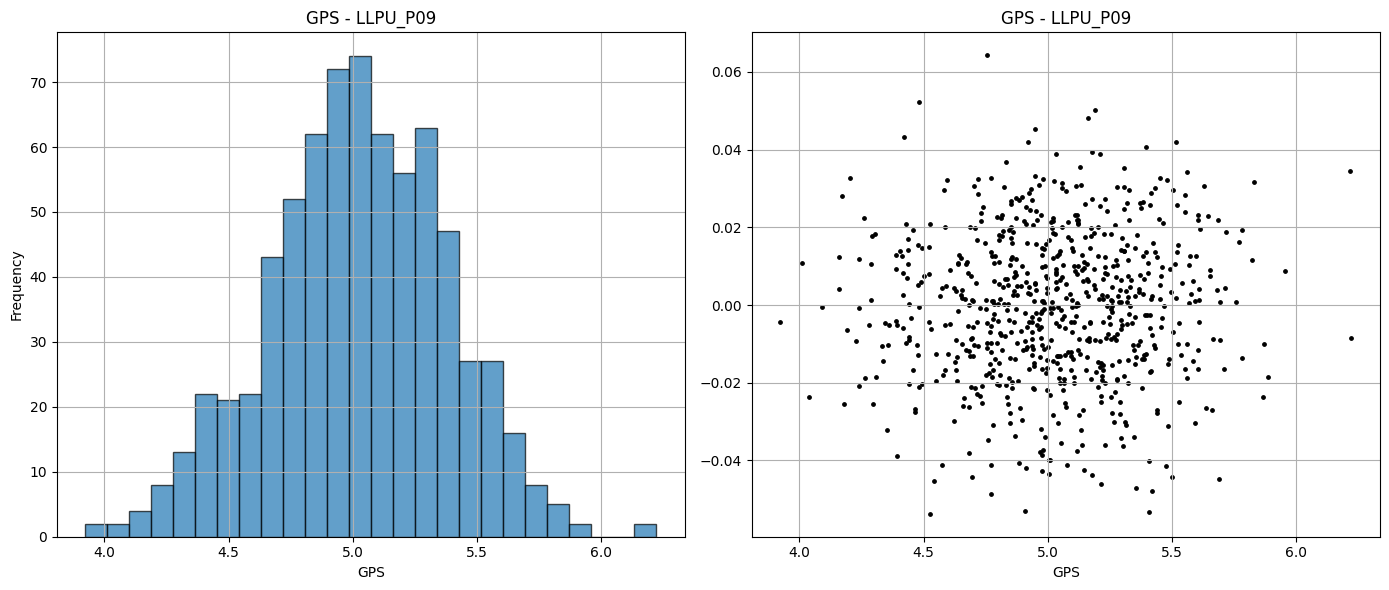

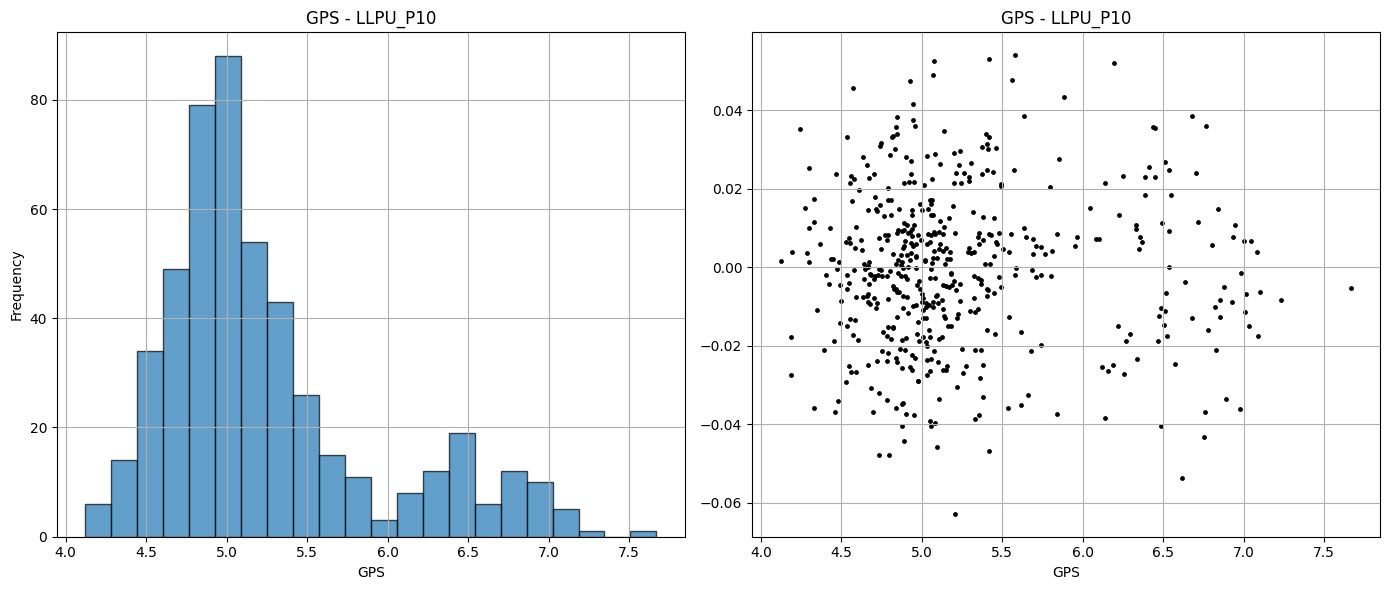

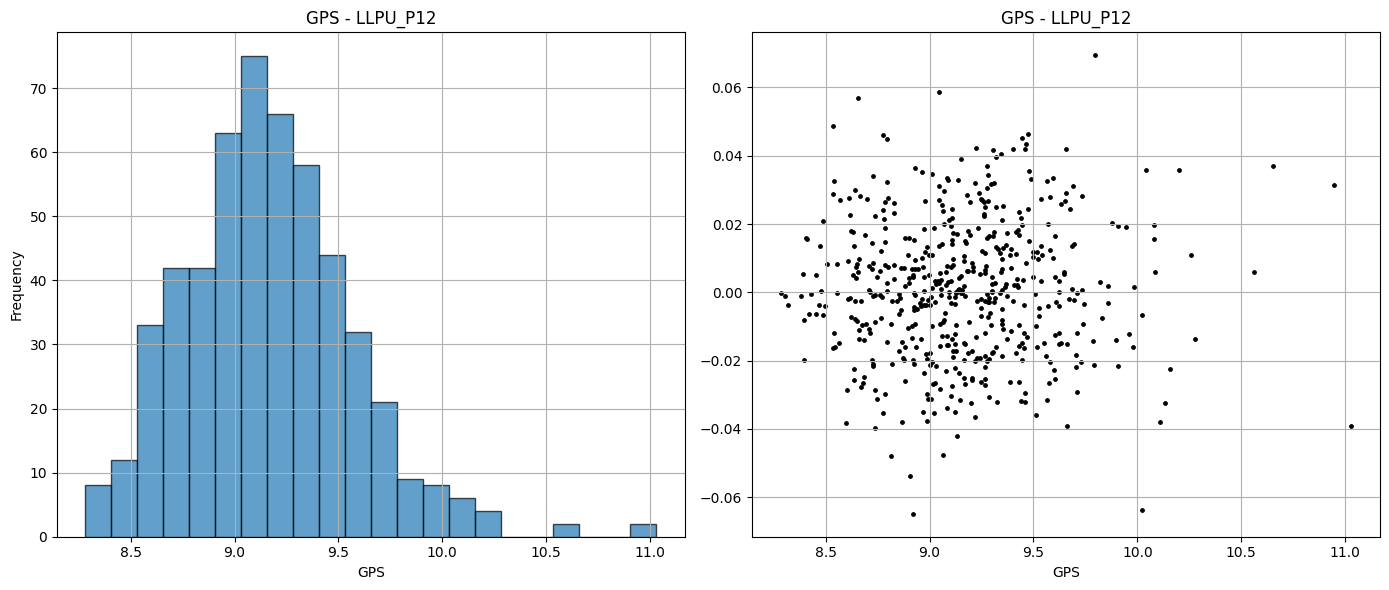

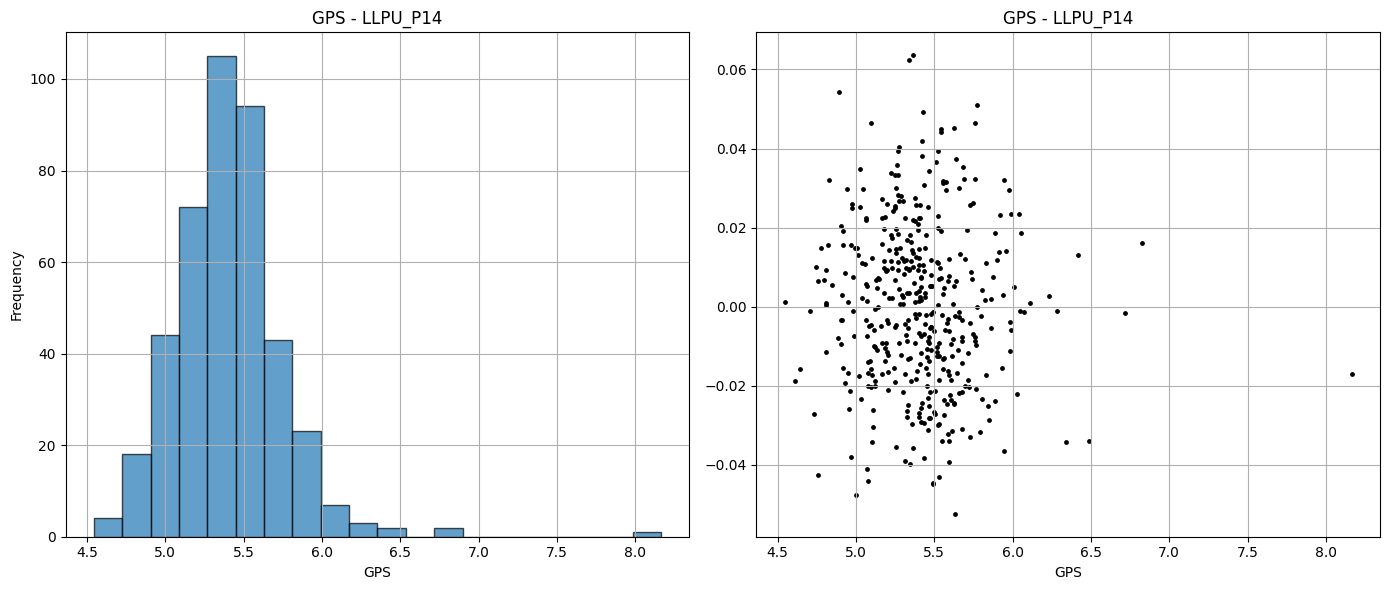

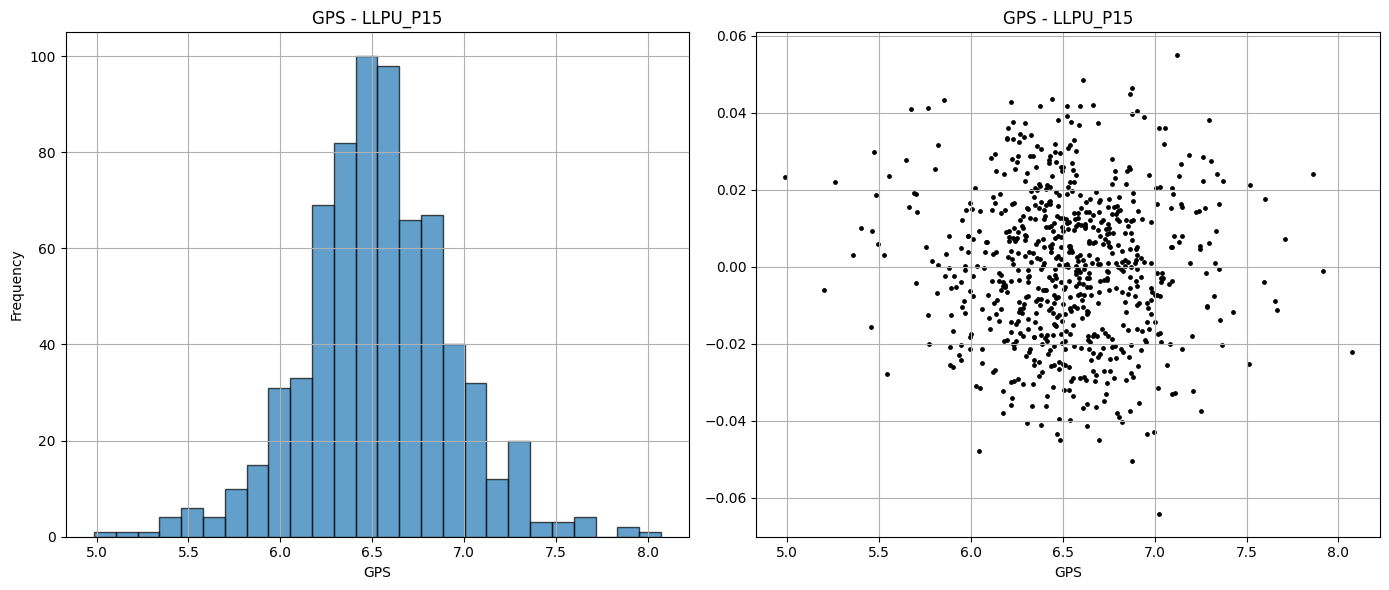

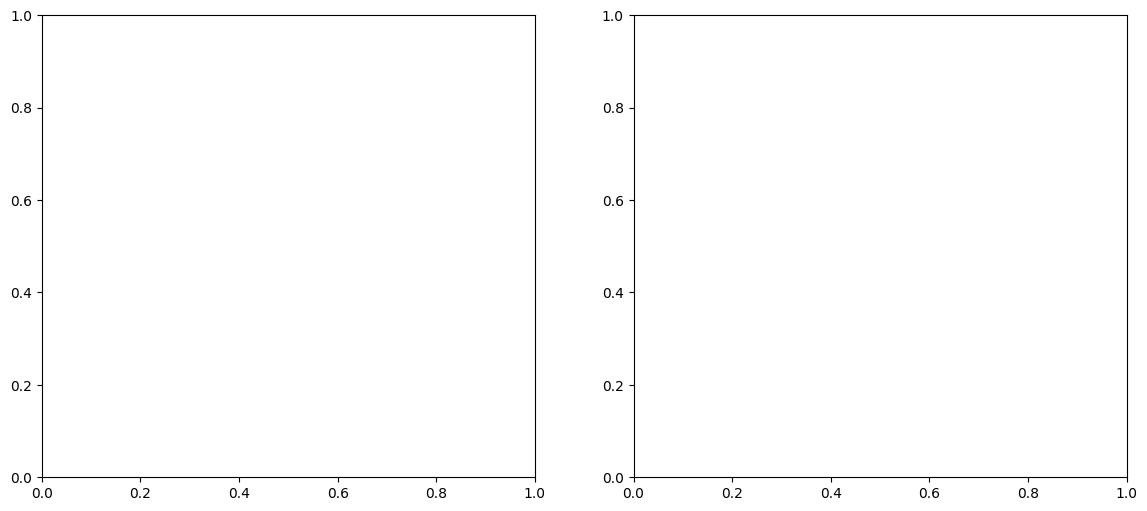

In [4]:
# Generate histogram and scatter plot side by side
import numpy as np
for index in range(12):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    GPS_values = GPS_full[index]
    # Histogram
    bincount = int(np.sqrt(len(GPS_values))) #Bin count selected based on the "square root rule (for now)"
    ax1.hist(GPS_values, bins=bincount, edgecolor='black', alpha=0.7)
    ax1.set_title(f'GPS - {participant_list[index]}')
    ax1.set_xlabel('GPS')
    ax1.set_ylabel('Frequency')
    ax1.grid(True)

    # Scatter plot
    y = (np.zeros(len(GPS_values))) + np.random.normal(0, 0.02, len(GPS_values))
    ax2.scatter(GPS_values, y, s=6, color='black')
    ax2.set_title(f'GPS - {participant_list[index]}')
    ax2.set_xlabel('GPS')
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f'Q:\\main_propellab\\Users\\Ng, Gabe\\Summer Student 2024\\LLPU_DataSummaries\\GPS\\{participant_list[index]}_GPS.jpg')

In [13]:
import re
import gait_metrics as gait_metrics
from gait_metrics import *

XsensGaitParser =  excel_reader_GN.XsensGaitDataParser()
storage_client = storage.Client()
part_strides = {}
part_gait_params = {}
part_kinematic_params = {}
control_strides = {}
control_gait_params = {}
control_kinematic_params = {}

temp_len = 0

partitioned_signals_dot = []
partitioned_signals_awinda_grouped = {}
target_SRs = []
nondesired_trial_nums = [4]
participant_of_interest = 14
orientation_tolerance = 10 # degrees
resize_len = 40
look_at_all_files = True
desired_filetypes = ['Baseline']
trials_accepted = 0
trials_total = 0

bucket_dir = 'gs://gaitbfb_propellab/'
def compile_gait_data(store_gait_cycles, store_gait_params, store_kin_params, filenames, trial_type_filter, print_filenames=False, look_at_all_files = True, desired_filetypes=None):   
 
    XsensGaitParser = excel_reader_GN.XsensGaitDataParser()  
    for i, file in enumerate(sorted(filenames)):
        trial_type = re.search(trial_type_filter, file).group(1)
        if(look_at_all_files or any(filetype in file for filetype in desired_filetypes)):
            XsensGaitParser.process_mvn_trial_data(os.path.join(bucket_dir, file))
            partitioned_mvn_data = XsensGaitParser.get_partitioned_mvn_data()
            gait_params = XsensGaitParser.get_gait_param_info()

            if trial_type in store_gait_cycles:
                for body_part in store_gait_cycles[trial_type]:
                    for i, side in enumerate(store_gait_cycles[trial_type][body_part]):
                        # for each part (pelvis, l_hip, r_knee, etc.), append strides to appropriate list
                        store_gait_cycles[trial_type][body_part][i] = store_gait_cycles[trial_type][body_part][i] + partitioned_mvn_data[body_part][i]

                store_gait_params[trial_type].append(gait_params['spatio_temp'])

                for joint in store_kin_params[trial_type]:
                    for i, side in enumerate(store_kin_params[trial_type][joint]):
                        store_kin_params[trial_type][joint][i] = np.append(store_kin_params[trial_type][joint][i], gait_params['kinematics'][joint][i], axis=0)

            else:
                store_gait_cycles[trial_type] = partitioned_mvn_data
                store_gait_params[trial_type] = [gait_params['spatio_temp']]
                store_kin_params[trial_type] = gait_params['kinematics']


bucket_name = 'gaitbfb_propellab/'
base_directory = bucket_name + 'Wearable Biofeedback System (REB-0448)/Data/Raw Data'
bucket_name = 'gaitbfb_propellab'
prefix = 'control_dir'
control_dir = 'Gait Quality Analysis/Data/Participant_Data/Processed Data/AbleBodied_Control/CSV'
blobs = storage_client.list_blobs(bucket_name, prefix = control_dir)
control_files = []
for blob in blobs:
    if('.csv' in blob.name):
        control_files.append(blob.name)

compile_gait_data(control_strides, control_gait_params, control_kinematic_params, control_files, 'CSV/(.*?)-00')        


aggregate_control_data = {}
strides_per_control = 10
for i, indiv in enumerate(control_strides.keys()):
    indices = np.arange(len(control_strides[indiv]['gyro_data'][0]))
    np.random.shuffle(indices)
    #control_strides_per_part.append(min(strides_per_control, len(indices)))
    
    if(i == 0):
        aggregate_control_data = control_strides[indiv]
        
        for signal_type in control_strides[indiv]:
            for j, side in enumerate(control_strides[indiv][signal_type]):
                aggregate_control_data[signal_type][j] = [control_strides[indiv][signal_type][j][indices[k]] for k in range(min(strides_per_control, len(indices))) ]
                    
                    
    else:
        # randomly sample 10 gait cycles from each able-bodied in control, or all gait cycles if less than 10
        for signal_type in control_strides[indiv]:
            for j, side in enumerate(control_strides[indiv][signal_type]):
                aggregate_control_data[signal_type][j] = aggregate_control_data[signal_type][j] + [control_strides[indiv][signal_type][j][indices[k]] 
                                                                                                   for k in range(min(strides_per_control, len(indices))) ]

# reshape all the kinematic signals to the size specified for the GPS (51, e.g. 2% increments across the gait cycles from HS to HS)
# store in partitioned_awinda_control

def reshape_vector(vectors_orig, new_size, num_axes=3):
    x_new = np.linspace(0, 100, new_size)
    trial_reshaped = []
    for stride in vectors_orig:
        x_orig = np.linspace(0, 100, len(stride))
        func_cubic = [interp.interp1d(x_orig, stride[:, i], kind='cubic') for i in range(num_axes)]
        vec_cubic = np.array([func_cubic[i](x_new) for i in range(num_axes)]).transpose()
        trial_reshaped.append(vec_cubic)
    return np.array(trial_reshaped)

partitioned_awinda_control = {}
partitioned_awinda_control['pelvis_orient'] = reshape_vector(aggregate_control_data['pelvis_orient'][0], new_size = 51)
partitioned_awinda_control['hip_angle'] = [reshape_vector(aggregate_control_data['hip_angle'][0], new_size = 51), reshape_vector(aggregate_control_data['hip_angle'][1], new_size = 51)]
partitioned_awinda_control['knee_angle'] = [reshape_vector(aggregate_control_data['knee_angle'][0], new_size = 51), reshape_vector(aggregate_control_data['knee_angle'][1], new_size = 51)]
partitioned_awinda_control['ankle_angle'] = [reshape_vector(aggregate_control_data['ankle_angle'][0], new_size = 51), reshape_vector(aggregate_control_data['ankle_angle'][1], new_size = 51)]

c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=

In [14]:
individual_signals = []

# Extract and reshape individual signals
individual_signals = []
gait_scores_list = []

for i in range(partitioned_awinda_gait['pelvis_orient'].shape[0]):
    signal_dict = {
        'pelvis_orient': partitioned_awinda_gait['pelvis_orient'][i].reshape(1, 51, 3),
        'hip_angle': [partitioned_awinda_gait['hip_angle'][0][i].reshape(1, 51, 3), partitioned_awinda_gait['hip_angle'][1][i].reshape(1, 51, 3)],
        'knee_angle': [partitioned_awinda_gait['knee_angle'][0][i].reshape(1, 51, 3), partitioned_awinda_gait['knee_angle'][1][i].reshape(1, 51, 3)],
        'ankle_angle': [partitioned_awinda_gait['ankle_angle'][0][i].reshape(1, 51, 3), partitioned_awinda_gait['ankle_angle'][1][i].reshape(1, 51, 3)]
    }
    individual_signals.append(signal_dict)

print(np.shape(individual_signals[0]['pelvis_orient']))    
print(np.shape(individual_signals[0]['hip_angle'][0]))

for signal in individual_signals:
    gait_scores = calc_gait_profile_score(signal, partitioned_awinda_control)
    gait_scores_list.append(gait_scores)


(1, 51, 3)
(1, 51, 3)


In [68]:
knee_roms = gait_params['spatio_temp'][14]
                    
# Apply the function to each sublist (left and right) within knee_ROMs
knee_ROMs_magnitude = [
    [sublist[:][0][-1], sublist[:][1][-1]]
    for sublist in knee_roms]

knee_ROMs = [
    sublist[:][prosth_side]
    for sublist in knee_ROMs_magnitude] 
                  
knee_roms_list.append(knee_ROMs)
print(knee_roms)
print(knee_ROMs)

print(ankle_ROM)

[[[10.051231 15.743379 34.936679]
  [ 5.78467   7.805017 33.028413]]

 [[ 9.942356 17.965179 35.300567]
  [ 6.704685  7.789404 32.58347 ]]

 [[10.523988 15.854882 34.337184]
  [ 7.610575  7.060281 34.00833 ]]

 [[10.753718 18.17127  36.112295]
  [ 8.027609  7.265825 33.530306]]

 [[10.62337  16.905658 34.056256]
  [ 7.850038  7.843706 32.355008]]

 [[10.250553 15.753785 33.437869]
  [ 7.546101  8.49474  32.650022]]]
[34.936679, 35.300567, 34.337184, 36.112295, 34.056256, 33.437869]
[]


[0.9545454545454546, 0.9696969696969697, 0.9538461538461539, 0.9841269841269841, 0.9841269841269841, 0.9384615384615385, 1.0, 0.9538461538461539, 0.9545454545454546, 0.9571428571428572, 1.1194029850746268, 0.9682539682539683, 0.953125, 0.9841269841269841, 0.9384615384615385, 0.9242424242424242, 0.9393939393939394, 0.9545454545454546, 0.9846153846153847, 0.9253731343283582, 0.9565217391304348, 0.9701492537313433, 0.9538461538461539, 1.0, 0.984375, 0.9841269841269841, 0.967741935483871, 1.0, 0.9692307692307692, 1.0161290322580645, 0.9242424242424242, 0.9545454545454546, 0.953125, 0.953125, 0.9393939393939394, 0.9384615384615385, 0.9117647058823529, 0.9577464788732394, 0.9583333333333334, 0.972972972972973, 0.92, 0.9852941176470589, 0.9855072463768116, 0.9305555555555556, 1.0294117647058822, 0.9857142857142858, 0.9852941176470589, 0.9027777777777778, 0.927536231884058, 0.9565217391304348, 0.9850746268656716, 0.9130434782608695, 0.918918918918919, 1.0, 0.9710144927536232, 1.015151515151515

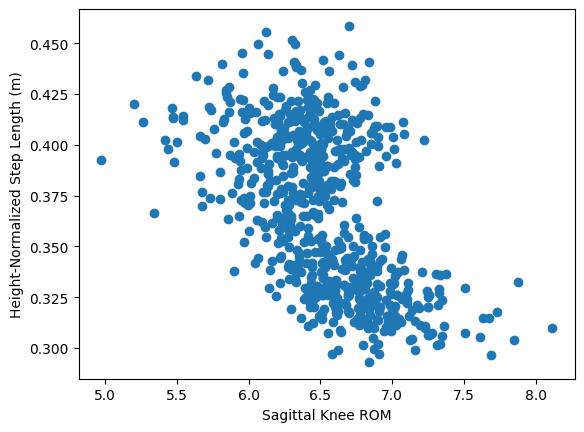

In [15]:

flattened_list = [item for sublist in knee_roms_list for item in sublist]

from scipy.stats import pearsonr 


X = stance_time_symmetry
Y = gait_scores_list
Z = step_lengths


print(X)
print(Y)
print(Z)

corr_XY, p_value_XY = pearsonr(X, Y)
corr_XZ, p_value_XZ = pearsonr(X, Z)
corr_YZ, p_value_YZ = pearsonr(Y, Z)

plt.scatter(Y,Z)
plt.xlabel("Sagittal Knee ROM")
plt.ylabel("Height-Normalized Step Length (m)")

print(f"Pearson's correlation coefficient between X and Y: {corr_XY:.4f}, p-value: {p_value_XY}")
print(f"Pearson's correlation coefficient between X and Z: {corr_XZ:.4f}, p-value: {p_value_XZ}")
print(f"Pearson's correlation coefficient between Y and Z: {corr_YZ:.4f}, p-value: {p_value_YZ}")

In [12]:
""" Data grouping/splitting pipeline:"""

""" Split the data into desired number of groups, and extract the first "target mean" from the first group. Subsequent target means are calculated as X% (percent grading) away from previous groups
    ex. if 3% is selected, means of groups will increment by 3% - the direction of incrementing (up/down) depends on whether reverse is selected 
    Iterate through indices in the gait parameter data (in this case, STSR) and append to a grouping if they are within a threshold from the target mean. 
    Sort both the gait parameter and corresponding gait cycles based on the chosen indices. 
"""

def finding_groupings(num_groups, gait_parameter, speed, cadence, gait_cycles, percent_grading, reverse=True):
    
    if reverse:
        percent_grading = -percent_grading
        values_sorted = sorted(gait_parameter, reverse=True)
        sorted_indices = np.argsort(gait_parameter)[::-1]  # Sort indices in descending order of stance time symmetry
    else:
        sorted_indices = np.argsort(gait_parameter)
        values_sorted = sorted(gait_parameter, reverse=False)

    n = len(gait_parameter)
    group_sizes = [n // num_groups + (1 if i < n % num_groups else 0) for i in range(num_groups)]
    target_means = [np.mean(values_sorted[:group_sizes[0]])]

    # Initializes the groups and the remaining values to be picked from
    groups = [[] for _ in range(num_groups)]
    speedlists = [[] for _ in range(num_groups)]
    cadencelists = [[] for _ in range(num_groups)]
    grouped_gait_cycles = [[] for _ in range(num_groups)]
    remaining_indices = sorted_indices[:]

    for i in range(1, num_groups):
        target_means.append(target_means[0] + percent_grading * i)

    for i in range(num_groups):
        target_mean = target_means[i]
        filtered_indices = [idx for idx in remaining_indices if abs(gait_parameter[idx] - target_mean) < percent_grading / 2]
        selected_indices = filtered_indices[:]
        groups[i].extend(gait_parameter[idx] for idx in selected_indices)
        speedlists[i].extend(speed[idx] for idx in selected_indices)
        cadencelists[i].extend(cadence[idx] for idx in selected_indices)
        
        grouped_gait_cycles[i].extend(gait_cycles[idx] for idx in selected_indices)
        remaining_indices = [idx for idx in remaining_indices if idx not in selected_indices]

    return groups, speedlists, cadencelists, grouped_gait_cycles, percent_grading            

""" Random Sampling Gait Cycles:"""

""" random_sampling: Randomly sample 50 gait cycles from group 1. This serves as the "first_mean" that will be compared to in adaptive subsampling.
    adaptive_subsample: Randomly sample 50 gait cycles from a given group. If it is within X% * i +/- tolerance (i is the index of the group (ex. group 2 = 1)), then that group is accepted.
    Otherwise, the maximum or minimum is removed and another value still available is added (depending on if the current percent difference is too high or too low)
    Handles if the means are decreasing or increasing (if percent_diff is negative or positive)
    Returns the indices of the groups, and these are used to update the new groups in random_sampling.
"""

def random_sampling(groups, speedlists, cadencelists,grouped_gait_cycles, sample_size=50):
    def adaptive_subsample(group, first_mean, i, percent_grading= 0.03, tolerance=0.005, sample_size=50, max_iterations=10000):
        available_indices = list(range(len(group)))  # Make a list that spans all the indices
        sample_indices = np.random.choice(available_indices, size=sample_size, replace=False)
        
        for idx in sample_indices:
            available_indices.remove(idx)  # Remove initial sample values from available values
        for _ in range(max_iterations):
            current_mean = np.mean([group[idx] for idx in sample_indices])
            percent_diff = current_mean - first_mean 
            target_diff = percent_grading * i

            if len(available_indices) == 0:
                raise ValueError("No candidates available to adjust the mean")
            
            if (target_diff - tolerance) <= abs(percent_diff) <= (target_diff + tolerance):
                return sample_indices
            
            if abs(percent_diff) < (target_diff - tolerance):
                if percent_diff < 0:
                    # Choose a new sample from the lower half
                    lower_idx = [idx for idx in available_indices if group[idx] <= np.percentile(group, 50)]
                    if lower_idx:
                        new_idx = np.random.choice(lower_idx)
                        sample_indices = np.append(sample_indices, new_idx)
                    else:
                        new_idx = np.random.choice(available_indices)
                        sample_indices = np.append(sample_indices, new_idx)
                    
                    available_indices.remove(new_idx)
                    sample_indices = np.delete(sample_indices, np.argmax([group[idx] for idx in sample_indices]))
                else:
                    # Choose a new sample from the upper half
                    higher_idx = [idx for idx in available_indices if group[idx] >= np.percentile(group, 50)]
                    if higher_idx:
                        new_idx = np.random.choice(higher_idx)
                        sample_indices = np.append(sample_indices, new_idx)
                    else:
                        new_idx = np.random.choice(available_indices)
                        sample_indices = np.append(sample_indices, new_idx)
                    
                    available_indices.remove(new_idx)
                    sample_indices = np.delete(sample_indices, np.argmin([group[idx] for idx in sample_indices]))
            else:
                if percent_diff > 0:
                    lower_idx = [idx for idx in available_indices if group[idx] <= np.percentile(group, 50)]
                    if lower_idx:
                        new_idx = np.random.choice(lower_idx)
                        sample_indices = np.append(sample_indices, new_idx)
                    else:
                        new_idx = np.random.choice(available_indices)
                        sample_indices = np.append(sample_indices, new_idx)
                    
                    available_indices.remove(new_idx)
                    sample_indices = np.delete(sample_indices, np.argmax([group[idx] for idx in sample_indices]))
                else:
                    # Choose a new sample from the upper half
                    higher_idx = [idx for idx in available_indices if group[idx] >= np.percentile(group, 50)]
                    if higher_idx:
                        new_idx = np.random.choice(lower_idx)
                        sample_indices = np.append(sample_indices, new_idx)
                    else:
                        new_idx = np.random.choice(available_indices)
                        sample_indices = np.append(sample_indices, new_idx)
                    
                    available_indices.remove(new_idx)
                    sample_indices = np.delete(sample_indices, np.argmin([group[idx] for idx in sample_indices]))

        raise ValueError("Could not find suitable subsample within the maximum number of iterations")

    indices_first_group = list(range(len(groups[0])))  
    sample_indices_first_group = np.random.choice(indices_first_group, size=sample_size*2, replace=False)
    group1_mean = np.mean([groups[0][idx] for idx in sample_indices_first_group]) # first mean used as the target for all subsequent groups
    
    random.shuffle(sample_indices_first_group)
    baseline_1_indices = sample_indices_first_group[:50]
    baseline_2_indices = sample_indices_first_group[50:]
    
    subsampled_values_baseline1 = [groups[0][j] for j in baseline_1_indices]
    subsampled_gait_cycles_baseline1 = [grouped_gait_cycles[0][j] for j in baseline_1_indices]
    
    subsampled_speed_baseline1 = [speedlists[0][j] for j in baseline_1_indices]
    subsampled_speed_baseline2 = [speedlists[0][j] for j in baseline_2_indices]
    subsampled_cadence_baseline1 = [cadencelists[0][j] for j in baseline_1_indices]
    subsampled_cadence_baseline2 = [cadencelists[0][j] for j in baseline_2_indices]
    
    subsampled_values_baseline2 = [groups[0][j] for j in baseline_2_indices]
    subsampled_gait_cycles_baseline2 = [grouped_gait_cycles[0][j] for j in baseline_2_indices]
    
    groups_subsampled_list = []
    speed_subsampled_list = []
    cadence_subsampled_list = []
    gaitcycles_subsampled_list = []
    
    groups_subsampled_list.append(subsampled_values_baseline1)
    groups_subsampled_list.append(subsampled_values_baseline2)
    
    speed_subsampled_list.append(subsampled_speed_baseline1)
    speed_subsampled_list.append(subsampled_speed_baseline2)
    
    cadence_subsampled_list.append(subsampled_cadence_baseline1)
    cadence_subsampled_list.append(subsampled_cadence_baseline2)
    
    gaitcycles_subsampled_list.append(subsampled_gait_cycles_baseline1)
    gaitcycles_subsampled_list.append(subsampled_gait_cycles_baseline2)
    
    #Only consider 3 groups here
    for i in range(1, 3):
        sample_indices = adaptive_subsample(np.array(groups[i]), group1_mean, i)
        subsampled_values = [groups[i][j] for j in sample_indices]
        subsampled_speed = [speedlists[i][j] for j in sample_indices]
        subsampled_cadence = [cadencelists[i][j] for j in sample_indices]
        subsampled_gait_cycles = [grouped_gait_cycles[i][j] for j in sample_indices]
        groups_subsampled_list.append(subsampled_values)
        gaitcycles_subsampled_list.append(subsampled_gait_cycles)
        speed_subsampled_list.append(subsampled_speed)
        cadence_subsampled_list.append(subsampled_cadence)
    
    return groups_subsampled_list, gaitcycles_subsampled_list, speed_subsampled_list,cadence_subsampled_list

""" Group splitting and sampling are called. Checks to see which direction the grouping should be done in, and only appends the groups that have at least 70 points"""

def check_group_configurations(speed, cadence, gait_split_parameter, raw_sensor_data, num_groups):
    percent_grading = 0.03
    groups, speedlists, cadencelists, grouped_gait_cycles, percent_grading  = finding_groupings(num_groups, gait_split_parameter, speed, cadence, raw_sensor_data, percent_grading, reverse=False)
    
    filtered_groups = []
    filtered_gait_groups = []
    filtered_speed = []
    filtered_cadence = []
    
    for i in range(len(groups)):
        if len(groups[i]) > 70:
            filtered_groups.append(groups[i])
            filtered_gait_groups.append(grouped_gait_cycles[i])
            filtered_speed.append(speedlists[i])
            filtered_cadence.append(cadencelists[i])
    
    if len(filtered_groups) < 3:
        groups, speedlists, cadencelists, grouped_gait_cycles, percent_grading  = finding_groupings(num_groups, gait_split_parameter, speed, cadence, raw_sensor_data, percent_grading, reverse=True)  # Try the other direction if requirements are not fulfilled
        filtered_groups = []
        filtered_gait_groups = []
        filtered_speed = []
        filtered_cadence = []
        
        for i in range(len(groups)):
            if len(groups[i]) > 70:
                filtered_groups.append(groups[i])
                filtered_gait_groups.append(grouped_gait_cycles[i])
                filtered_speed.append(speedlists[i])
                filtered_cadence.append(cadencelists[i])

        if len(filtered_groups) < 3:
            raise ValueError("Insufficient group sizes available for this participant")
    
    groups, gaitcycles,speed, cadence = random_sampling(filtered_groups, filtered_speed, filtered_cadence, filtered_gait_groups, sample_size=50)
    
    return groups, gaitcycles, speed, cadence

In [29]:
XsensGaitParser =  excel_reader.XsensGaitDataParser() #Different excel reader file, which contains the spatiotemporal parameters not pertaining to the INI
storage_client = storage.Client()
bucket_name = 'gaitbfb_propellab/'
base_directory = bucket_name + 'Wearable Biofeedback System (REB-0448)/Data/Raw Data'
bucket_name = 'gaitbfb_propellab'
blobs = storage_client.list_blobs(bucket_name, prefix = base_directory)
prefix_from_bucket = 'Wearable Biofeedback System (REB-0448)/Data/Raw Data/' 

#participant_list = ['LLPU_P09','LLPU_P10','LLPU_P12','LLPU_P14','LLPU_P15']
participant_list = ['LLPU_P01','LLPU_P02','LLPU_P03','LLPU_P04','LLPU_P05','LLPU_P06','LLPU_P08','LLPU_P09','LLPU_P10','LLPU_P12','LLPU_P15']
arrangements = ['pelvis','upper','lower']


def initialize_csv(file_path):
    if not os.path.isfile(file_path):
        with open(file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Participant', 'Measure', 'Mean', 'Standard Deviation', 'Min', 'Max', 'Median'])

output_csv = "C:\\Users\\ekuep\\Desktop\\participant_speed.csv"

# Initialize the CSV file if it doesn't exist
initialize_csv(output_csv)
    
def calculate_statistics(data):
    stats_dict = {
        'mean': np.mean(data),
        'std': np.std(data),
        'min': np.min(data),
        'max': np.max(data),
        'median': np.median(data)
    }
    return stats_dict

def organize_signals(sensor_mappings, gyro_signal, accel_signal):
    combined_signals = {}
    for location, sensor in sensor_mappings.items():
        reshaped_gyro = reshape_vector(gyro_signal[sensor], 40, 3)
        reshaped_accel = reshape_vector(accel_signal[sensor], 40, 3)
        combined_signals[location] = np.concatenate((reshaped_gyro, reshaped_accel), axis=2) #Concatenates to gyro x,y,z and accel x,y,z
    return combined_signals

def reshape_vector(vectors_orig, new_size=40, num_axes=3):
    x_new = np.linspace(0, 100, new_size)
    trial_reshaped = []
    for stride in vectors_orig:
        x_orig = np.linspace(0, 100, len(stride))
        func_cubic = [interp.interp1d(x_orig, stride[:, i], kind='cubic') for i in range(num_axes)]
        vec_cubic = np.array([func_cubic[i](x_new) for i in range(num_axes)]).transpose()
        trial_reshaped.append(vec_cubic)
    return np.array(trial_reshaped)

def get_participant_info(participant_id):
    participant = participant_info[participant_info['Participant_ID'] == participant_id]
    if not participant.empty:
        height = participant.iloc[0]['Height']
        side = int(participant.iloc[0]['Side'])
        return height, side
    else:
        return None, None

#Dictionary to map the sensor locations to their IDs.
sensor_mappings = {
    'pelvis': 1,
    'UpperR': 2,
    'LowerR': 3,
    'UpperL': 5,
    'LowerL': 6
}
     
for participant in participant_list:
    print(f"Processing participant {participant}")
 
    directory = prefix_from_bucket + participant + '/Excel_Data_Trimmed'
    blobs = storage_client.list_blobs(bucket_or_name=bucket_name, prefix=directory.replace("\\", "/"))
    part_strides = {}
    part_gait_params = {}
    part_kinematic_params = {}
    part_raw_sensor = []
    trial_type = 'LLPU'
    height_normalized = True
    
    part_gait_params_INI = {}
    part_strides_INI = {}
   
    logging.info(f"Processing participant {participant}")
    if blobs:
        for blob in blobs:
            if blob.name.endswith('.csv'):
                try:
                    XsensGaitParser.process_mvn_trial_data(f"gs://{bucket_name}/{blob.name}")
                    partitioned_mvn_data = XsensGaitParser.get_partitioned_mvn_data()
                    gait_params = XsensGaitParser.get_gait_param_info()
                    combined_signals = organize_signals(sensor_mappings, partitioned_mvn_data['gyro_data'], partitioned_mvn_data['acc_data'])
                    pelvis_data = combined_signals['pelvis']
                    upper_data = np.concatenate((combined_signals['UpperR'], combined_signals['UpperL']), axis=2)  # Concatenate by last axis
                    lower_data = np.concatenate((combined_signals['LowerR'], combined_signals['LowerL']), axis=2)  # Concatenate by last axis
                    full_sensors = np.concatenate((pelvis_data,upper_data,lower_data),axis=2)
                    part_raw_sensor.append(full_sensors)

                    if trial_type in part_strides:
                        for body_part in part_strides[trial_type]:
                            for i, side in enumerate(part_strides[trial_type][body_part]):
                                # for each part (pelvis, l_hip, r_knee, etc.), append strides to appropriate list
                                part_strides[trial_type][body_part][i] = part_strides[trial_type][body_part][i] + partitioned_mvn_data[body_part][i]
                        
                        part_gait_params[trial_type].append(gait_params['spatio_temp'])
                        
                        for joint in part_kinematic_params[trial_type]:
                            for i, side in enumerate(part_kinematic_params[trial_type][joint]):
                                part_kinematic_params[trial_type][joint][i] = np.append(part_kinematic_params[trial_type][joint][i], gait_params['kinematics'][joint][i], axis=0) 

                    else:
                        part_strides[trial_type] = partitioned_mvn_data
                        part_kinematic_params[trial_type] = gait_params['kinematics']
                        part_gait_params[trial_type] = [gait_params['spatio_temp']]
                    
                    file_name = os.path.basename(blob.name)
                    
                except IndexError as e: #Exception based on an Index Error encountered in excel_reader_gcp.py **
                #print(f"File skipped: gs://{bucket_name}/{blob.name} due to error: {e}")
                    continue   
                
    
    if trial_type in part_gait_params:
        
        stance_time_symmetry = [item for sublist in [i[11] for i in part_gait_params[trial_type]] for item in sublist]
        # speed = [item for sublist in [i[15] for i in part_gait_params[trial_type]] for item in sublist]
        # cadence = [item for sublist in [i[16] for i in part_gait_params[trial_type]] for item in sublist]
        
        flattened_raw_sensor = []
        part_strides_list = []
        for sublist in part_raw_sensor:
            for item in sublist:
                flattened_raw_sensor.append(item) #Flatten to individual gait cycles 
        
        if participant == "LLPU_P08":
            ordered_groups, ordered_gaitcycles, speed, cadence = check_group_configurations(speed, cadence, stance_time_symmetry, flattened_raw_sensor, 6)
        else:
            ordered_groups, ordered_gaitcycles, speed, cadence = check_group_configurations(speed, cadence, stance_time_symmetry, flattened_raw_sensor, 4)
        
        flattened_speed = np.array(speed).flatten()
        flattened_cadence = np.array(cadence).flatten()
       
        speed_stats = calculate_statistics(flattened_speed)
        cadence_stats = calculate_statistics(flattened_cadence)

        # Log the statistics into the CSV file
        with open(output_csv, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([participant, 'Speed', speed_stats['mean'], speed_stats['std'], speed_stats['min'], speed_stats['max'], speed_stats['median']])
            writer.writerow([participant, 'Cadence', cadence_stats['mean'], cadence_stats['std'], cadence_stats['min'], cadence_stats['max'], cadence_stats['median']])

        # Optionally, print the statistics to the console for verification
        print(f"Statistics for {participant} - Speed: {speed_stats}")
        print(f"Statistics for {participant} - Cadence: {cadence_stats}")
        

Processing participant LLPU_P01
Statistics for LLPU_P01 - Speed: {'mean': 1.1916760746336041, 'std': 0.14237134716963326, 'min': 1.0015753364520745, 'max': 1.7292977365206486, 'median': 1.1574874281702148}
Statistics for LLPU_P01 - Cadence: {'mean': 106.54126965496424, 'std': 6.613312976860938, 'min': 97.5609756097561, 'max': 131.86813186813185, 'median': 104.34782608695653}
Processing participant LLPU_P02
Statistics for LLPU_P02 - Speed: {'mean': 1.2275454132315733, 'std': 0.08518549292742288, 'min': 0.9763487222557538, 'max': 1.5140324562419958, 'median': 1.2132910095440985}
Statistics for LLPU_P02 - Cadence: {'mean': 94.0379285731972, 'std': 4.075673571743347, 'min': 82.75862068965517, 'max': 105.26315789473685, 'median': 93.02325581395348}
Processing participant LLPU_P03
Statistics for LLPU_P03 - Speed: {'mean': 0.9665389319827059, 'std': 0.06044381456625536, 'min': 0.8393073441201756, 'max': 1.233041345109467, 'median': 0.9580577192711497}
Statistics for LLPU_P03 - Cadence: {'mean

c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Statistics for LLPU_P08 - Speed: {'mean': 0.9028902965687058, 'std': 0.05977279958469134, 'min': 0.7279974030520417, 'max': 1.0543505471427188, 'median': 0.9011287471447027}
Statistics for LLPU_P08 - Cadence: {'mean': 94.25712990188116, 'std': 2.825564589948994, 'min': 86.33093525179856, 'max': 103.44827586206897, 'median': 94.48818897637794}
Processing participant LLPU_P09
Statistics for LLPU_P09 - Speed: {'mean': 1.3156739244556217, 'std': 0.05846146699608011, 'min': 1.1876351781679493, 'max': 1.5098268228818104, 'median': 1.3098842809542663}
Statistics for LLPU_P09 - Cadence: {'mean': 111.73063000823025, 'std': 1.9599193245001683, 'min': 101.6949152542373, 'max': 115.38461538461537, 'median': 112.14953271028037}
Processing participant LLPU_P10
Statistics for LLPU_P10 - Speed: {'mean': 1.1473785818113271, 'std': 0.05180110124808901, 'min': 0.9671244386620926, 'max': 1.2986466875083231, 'median': 1.150930752796921}
Statistics for LLPU_P10 - Cadence: {'mean': 111.05638234079393, 'std':

200
